In [1]:
import yaml
import mysql.connector
import os
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import squarify
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import folium

import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.stats import kstest, norm
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import chi2_contingency

# Now you can use chi2_contingency function in your code


#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Load the YAML file
with open("D:\Telangana_Growth_Analysis\db_config.yaml", 'r') as file:
    db_config = yaml.safe_load(file)

# Connect to the database
connection = mysql.connector.connect(**db_config)
cursor = connection.cursor()

![Image Title](https://raw.githubusercontent.com/nani2357/My_dataset_repo/3cd2b82f9503ef651b21fc385222741c47b5b7e8/schema_model.png)

In [3]:
# SQL query to join 'fact_stamps' and 'dim_districts' on 'dist_code'

query = """
    select * from investments
    inner join districts on investments.dist_code = districts.dist_code
    """
# Use pandas to run the query and store the result in a DataFrame
investments = pd.read_sql(query, connection)

# Sort the DataFrame by the 'id' column in ascending order
investments.sort_values(by='id', ascending=True, inplace=True)
investments.reset_index(drop=True, inplace=True)


# Load the 'dim_date' table into a DataFrame
dim_date = pd.read_sql("SELECT * FROM dim_date", connection)

# Merge the 'vehicles' DataFrame with the 'dim_date' DataFrame on the 'month' column
investments = pd.merge(investments, dim_date, on='month', how='inner')
# Display the first few rows of the merged DataFrame

# Set Pandas display options to show all columns
pd.set_option('display.max_columns', None)
investments.head()

id dist_code       month                              sector  \
0   1      14_1  2019-04-01                         Engineering   
1   2      19_1  2019-04-01                         Engineering   
2   3      20_3  2019-04-01                    Wood and Leather   
3   4      20_3  2019-04-01                            Textiles   
4   5      21_5  2019-04-01  Electrical and Electronic Products   

   investment_in_cr  number_of_employees dist_code            district  mmm  \
0              2.32                   15      14_1      Mahabubnagar\r  Apr   
1              0.63                   13      19_1          Adilabad\r  Apr   
2              0.20                    8      20_3  Rajanna Sircilla\r  Apr   
3              0.27                   27      20_3  Rajanna Sircilla\r  Apr   
4              0.12                    5      21_5       Mahabubabad\r  Apr   

  quarter  fiscal_year  
0      Q1         2019  
1      Q1         2019  
2      Q1         2019  
3      Q1         2019  
4      Q1         2019

In [4]:
#The \r is a carriage return character. 
# it can remove it from the district column using the str.replace method provided by pandas.

investments['district'] = investments['district'].str.replace('\r', '')

# drop dis_code
investments.drop(columns=['dist_code','dist_code'], inplace=True)

investments.head()

id       month                              sector  investment_in_cr  \
0   1  2019-04-01                         Engineering              2.32   
1   2  2019-04-01                         Engineering              0.63   
2   3  2019-04-01                    Wood and Leather              0.20   
3   4  2019-04-01                            Textiles              0.27   
4   5  2019-04-01  Electrical and Electronic Products              0.12   

   number_of_employees          district  mmm quarter  fiscal_year  
0                   15      Mahabubnagar  Apr      Q1         2019  
1                   13          Adilabad  Apr      Q1         2019  
2                    8  Rajanna Sircilla  Apr      Q1         2019  
3                   27  Rajanna Sircilla  Apr      Q1         2019  
4                    5       Mahabubabad  Apr      Q1         2019

In [5]:
investments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5753 entries, 0 to 5752
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5753 non-null   int64  
 1   month                5753 non-null   object 
 2   sector               5753 non-null   object 
 3   investment_in_cr     5753 non-null   float64
 4   number_of_employees  5753 non-null   int64  
 5   district             5753 non-null   object 
 6   mmm                  5753 non-null   object 
 7   quarter              5753 non-null   object 
 8   fiscal_year          5753 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 449.5+ KB


In [6]:
# change date to datetime type

investments['month'] = pd.to_datetime(investments['month'])

In [7]:
investments.describe()

id  investment_in_cr  number_of_employees  fiscal_year
count  5753.000000       5753.000000          5753.000000  5753.000000
mean   2877.000000         17.231975           117.344168  2020.519555
std    1660.892381        257.427150          1398.725287     1.109453
min       1.000000          0.000000             0.000000  2019.000000
25%    1439.000000          0.220000             7.000000  2020.000000
50%    2877.000000          0.740000            15.000000  2021.000000
75%    4315.000000          3.120000            40.000000  2021.000000
max    5753.000000      17793.350000         57000.000000  2022.000000

### Investment and Employee Analysis

#### Investment (in Cr):

- **Range:** The investments range from a minimum of 0 Cr to a substantial 17,793.35 Cr.
- **Central Tendency:** On average, entities have an investment of approximately 17.23 Cr.
- **Variability:** The standard deviation is 257.43, indicating a wide spread in the investment amounts across entities.
- **Distribution:** 
  - Half of the entities have investments less than or equal to 0.74 Cr.
  - 25% have investments of 0.22 Cr or less.
  - 75% have investments of 3.12 Cr or less.

#### Number of Employees:

- **Range:** Entities have employee counts ranging from 0 to a significant 57,000.
- **Central Tendency:** The average number of employees in these entities is around 117.34. However, this average is influenced by outliers, as the median (or the 50th percentile) is only 15.
- **Variability:** A high standard deviation of 1,398.73 suggests a significant variation in the number of employees across entities.
- **Distribution:**
  - 25% of entities have 7 employees or fewer.
  - 75% have 40 employees or fewer.
  
This suggests that a majority of entities in this dataset are relatively small in size.


In [8]:
# Load the GeoJSON data
map_file = (r"D:\Telangana_Growth_Analysis\Telangana_Shape_Files\telangana_district_map.json")
geo_data = gpd.read_file(map_file)

In [9]:
#%matplotlib inline
# Create the profile report
#profile = ProfileReport(investments, title="Profiling Report")

# Specify the path to save the report
#output_file_path = "D:\\Telangana_Growth_Analysis\\y_data\\profiling_report.html"

# Save the report to the specified path
#profile.to_file(output_file_path)

In [10]:
investments.columns

Index(['id', 'month', 'sector', 'investment_in_cr', 'number_of_employees',
       'district', 'mmm', 'quarter', 'fiscal_year'],
      dtype='object')

In [11]:
investments[investments['investment_in_cr'] == investments['investment_in_cr'].max()]

id      month                                         sector  \
1177  1178 2020-02-01  Real Estate,Industrial Parks and IT Buildings   

      investment_in_cr  number_of_employees    district  mmm quarter  \
1177          17793.35                25419  Rangareddy  Feb      Q4   

      fiscal_year  
1177         2019

In [12]:
investments[investments['number_of_employees'] == investments['number_of_employees'].max()]

id      month                                         sector  \
1065  1066 2020-01-01  Real Estate,Industrial Parks and IT Buildings   

      investment_in_cr  number_of_employees    district  mmm quarter  \
1065             394.0                57000  Rangareddy  Jan      Q4   

      fiscal_year  
1065         2019

In [13]:
investments.nlargest(5, 'investment_in_cr')

id      month                                             sector  \
1177  1178 2020-02-01      Real Estate,Industrial Parks and IT Buildings   
939    940 2019-12-01  Fertlizers Organic and Inorganic,Pesticides,In...   
4178  4179 2022-03-01      Real Estate,Industrial Parks and IT Buildings   
5328  5329 2022-12-01                                 Plastic and Rubber   
5448  5449 2023-01-01                                 Plastic and Rubber   

      investment_in_cr  number_of_employees    district  mmm quarter  \
1177          17793.35                25419  Rangareddy  Feb      Q4   
939            5254.28                  450  Peddapalli  Dec      Q3   
4178           1862.73                  144  Rangareddy  Mar      Q4   
5328           1556.07                  307  Rangareddy  Dec      Q3   
5448           1553.00                 1812  Sangareddy  Jan      Q4   

      fiscal_year  
1177         2019  
939          2019  
4178         2021  
5328         2022  
5448         2022

In [14]:
investments.nlargest(5, 'number_of_employees')

id      month                                         sector  \
1065  1066 2020-01-01  Real Estate,Industrial Parks and IT Buildings   
2628  2629 2021-02-01  Real Estate,Industrial Parks and IT Buildings   
170    171 2019-05-01  Real Estate,Industrial Parks and IT Buildings   
2697  2698 2021-03-01  Real Estate,Industrial Parks and IT Buildings   
1681  1682 2020-07-01  Real Estate,Industrial Parks and IT Buildings   

      investment_in_cr  number_of_employees    district  mmm quarter  \
1065            394.00                57000  Rangareddy  Jan      Q4   
2628              0.00                40541  Rangareddy  Feb      Q4   
170             847.82                40250  Rangareddy  May      Q1   
2697              0.00                31315  Rangareddy  Mar      Q4   
1681            149.00                27000  Rangareddy  Jul      Q2   

      fiscal_year  
1065         2019  
2628         2020  
170          2019  
2697         2020  
1681         2020

In [15]:
investments[(investments['investment_in_cr'] == 0) | (investments['number_of_employees'] == 0)]

id      month                                             sector  \
8        9 2019-04-01                                        Engineering   
44      45 2019-04-01                         Granite and Stone Crushing   
45      46 2019-04-01                      Pharmaceuticals and Chemicals   
72      73 2019-04-01                                   Wood and Leather   
74      75 2019-04-01                                 Plastic and Rubber   
...    ...        ...                                                ...   
3974  3975 2022-01-01                                   Wood and Leather   
4017  4018 2022-01-01  Cement, Cement & Concrete Products, Fly Ash Br...   
5004  5005 2022-09-01                         Granite and Stone Crushing   
5110  5111 2022-09-01                                 Paper and Printing   
5598  5599 2023-02-01                      Pharmaceuticals and Chemicals   

      investment_in_cr  number_of_employees             district  mmm quarter  \
8                 0.03                    0               Nirmal  Apr      Q1   
44                0.00                    5   Medchal_Malkajgiri  Apr      Q1   
45                0.00                   75  Yadadri Bhuvanagiri  Apr      Q1   
72                0.00                   12           Sangareddy  Apr      Q1   
74               33.60                    0           Sangareddy  Apr      Q1   
...                ...                  ...                  ...  ...     ...   
3974              0.00                    8               Nirmal  Jan      Q4   
4017              0.00                    0             Suryapet  Jan      Q4   
5004              0.00                  104         Mahabubnagar  Sep      Q2   
5110              0.00                  200           Sangareddy  Sep      Q2   
5598              0.00                   60                Medak  Feb      Q4   

      fiscal_year  
8            2019  
44           2019  
45           2019  
72           2019  
74           2019  
...           ...  
3974         2021  
4017         2021  
5004         2022  
5110         2022  
5598         2022  

[102 rows x 9 columns]

In [16]:
# Box plot
fig_box = go.Figure()

fig_box.add_trace(go.Box(y=investments['investment_in_cr'], name='Investment in Cr'))
fig_box.add_trace(go.Box(y=investments['number_of_employees'], name='Number of Employees'))
fig_box.update_layout(title_text="Box Plot of Investment and Number of Employees")

fig_box.show()

# Violin plot
fig_violin = go.Figure()

fig_violin.add_trace(go.Violin(y=investments['investment_in_cr'], box_visible=True, line_color='blue', name='Investment in Cr'))
fig_violin.add_trace(go.Violin(y=investments['number_of_employees'], box_visible=True, line_color='green', name='Number of Employees'))
fig_violin.update_layout(title_text="Violin Plot of Investment and Number of Employees")

fig_violin.show()

Assuming data is correct, there extreme outliers  

**Note on Outliers in the Data:**

The dataset contains some extreme outliers, particularly in the 'investment_in_cr' and 'number_of_employees' columns:

- The most extreme outlier in the 'investment_in_cr' column is a staggering 17,793.35 Cr.

- The next highest investment value is significantly lower, standing at 5,254 Cr.

- Interestingly, 75% of the data points have investments below the threshold of 3.15 Cr, highlighting the substantial variation in investment amounts.

- On the employee front, the dataset includes an entity with an extraordinarily high employee count of 57,000.

- While the average number of employees across entities is approximately 117.34, it's essential to note that this average is significantly influenced by these outliers. The median value, which provides a more robust representation, stands at just 15.

- The majority of entities, precisely 75%, have a workforce of 40 employees or fewer, underscoring the prevalence of relatively smaller-sized entities in the dataset.

In [17]:
investments['sector'].value_counts()

Food Processing                                                                1065
Engineering                                                                     692
Cement, Cement & Concrete Products, Fly Ash Bricks                              659
Agro based incl Cold Storages                                                   579
Granite and Stone Crushing                                                      432
Pharmaceuticals and Chemicals                                                   353
Plastic and Rubber                                                              328
Others                                                                          301
Beverages                                                                       274
Wood and Leather                                                                233
Textiles                                                                        209
Paper and Printing                                                          

In [18]:
# Group by month
grouped_data = investments.groupby('month').agg({
    'investment_in_cr': 'sum',
    'number_of_employees': 'sum'
}).reset_index()

# Function to plot individual columns with specified color
def plot_individual_column(column_name, title, color):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data[column_name], 
                             mode='lines+markers',
                             line=dict(color=color)))
    fig.update_layout(title=title,
                      xaxis_title='Month/Year',
                      yaxis_title='Value',
                      template="plotly_dark")
    fig.show()

# Plot for 'Investment in Cr' in blue
plot_individual_column('investment_in_cr', 'Monthly Trends for Investment in Cr', 'blue')

# Plot for 'Number of Employees' in green
plot_individual_column('number_of_employees', 'Monthly Trends for Number of Employees', 'green')

# Problem Statement 8
## List down the top 5 sectors that have witnessed the most significant investments in FY 2022.

In [19]:
# Filter the data for the fiscal year 2022
fy_2022 = investments[investments['fiscal_year'] == 2022]

#Group by the 'sector' column
sector_grouped = fy_2022.groupby('sector')

#Sum the 'investment_in_cr' column for each sector
sector_investments = sector_grouped['investment_in_cr'].sum()

In [20]:
# Convert the sector_investments series into a DataFrame and reset the index
sector_investments_df = sector_investments.reset_index()

# Sort the DataFrame based on the investment values (from highest to lowest)
sorted_sectors_df = sector_investments_df.sort_values(by='investment_in_cr', ascending=True).reset_index(drop=True)

# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment', y=sorted_sectors_df['sector'], x=sorted_sectors_df['investment_in_cr'], orientation='h')
])

# Define the title string
plot_title = "Top Sectors with the Most Significant Investments for FY 2022"

# ... [rest of your code remains unchanged]

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Investment in Cr',
    yaxis_title='Sector',
    template="plotly_dark",
    height=800,
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

# Save the plot (modify the path as per your requirements)
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Top Sectors with the Most Significant Investments for FY 2022.html


In [21]:
#Sort the results in descending order based on the summed investments
sorted_sectors = sector_investments.sort_values(ascending=False)

# 5. Select the top 5 sectors
top_5_sectors = sorted_sectors.head(5)

top_5_sectors

sector
Plastic and Rubber                               5855.62
Pharmaceuticals and Chemicals                    2181.66
Real Estate,Industrial Parks and IT Buildings    2127.30
Solar and Other Renewable Energy                 2052.98
Engineering                                      1877.53
Name: investment_in_cr, dtype: float64

In [22]:
# Define colors for the bars
colors = ['red', 'blue', 'green', 'yellow', 'purple']
# Plotting
fig = go.Figure(data=[
    go.Bar(name=sector, x=[sector], y=[top_5_sectors[sector]])#, marker_color=color)
    for sector, color in zip(top_5_sectors.index, colors)
])

# Update layout
fig.update_layout(
    title="Top 5 Sectors with the Most Significant Investments for FY 2022",
    xaxis_title='Sector',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    height=600,
    showlegend=False,
)

# Define the title string for saving the plot
plot_title = "Top_5_Sectors_with_Most_Significant_Investments_FY_2022"

# Save the plot to the specified directory
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Top_5_Sectors_with_Most_Significant_Investments_FY_2022.html


In [23]:
# Group by sector and sum the number of employees for the top 5 sectors
employment_in_top_sectors = fy_2022[fy_2022['sector'].isin(top_5_sectors.index)].groupby('sector')['number_of_employees'].sum()
employment_in_top_sectors = employment_in_top_sectors.sort_values(ascending=False)
#Plotting
fig = go.Figure(data=[
    go.Bar(name='Number of Employees', x=employment_in_top_sectors.index, y=employment_in_top_sectors.values)
   
])

# Update layout
fig.update_layout(
    title="Number of Employees in the Top 5 Sectors for FY 2022",
    xaxis_title='Sector',
    yaxis_title='Number of Employees',
    template="plotly_dark",
    height=600,
    showlegend=False
)

# Define the title string for saving the plot
plot_title = "Number_of_Employees_in_Top_5_Sectors_FY_2022"

# Save the plot to the specified directory
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Number_of_Employees_in_Top_5_Sectors_FY_2022.html


## Top 5 Investment Sectors in FY 2022

The top 5 sectors that witnessed the most significant investments in FY 2022 are:

1. Plastic and Rubber: 5855.62 crores
2. Pharmaceuticals and Chemicals: 2181.66 crores
3. Real Estate, Industrial Parks, and IT Buildings: 2127.30 crores
4. Solar and Other Renewable Energy: 2052.98 crores
5. Engineering: 1877.53 crores

### Reasons for High Investments

- **Plastic and Rubber:** The growth in this sector might be influenced by increased demand for packaging, especially in e-commerce, and the rapid expansion of the automobile industry which uses a lot of plastic and rubber components.

- **Pharmaceuticals and Chemicals:** The pharmaceutical industry has witnessed significant growth due to the global health crisis. The demand for medicines, research, and vaccine development might have attracted more investments.

- **Real Estate, Industrial Parks, and IT Buildings:** Urbanization, the growth of IT hubs, and favorable government policies to attract tech companies could be reasons for growth in this sector.

- **Solar and Other Renewable Energy:** With the global emphasis on sustainable energy solutions and reducing carbon emissions, there's a push towards renewable energy sources, especially solar.

- **Engineering:** The engineering sector's growth can be attributed to infrastructural development, urbanization, and technological advancements.

### Employment Numbers

The number of employees in the top 5 sectors for FY 2022 are:

1. Engineering: 12,025 employees
2. Pharmaceuticals and Chemicals: 13,591 employees
3. Plastic and Rubber: 9,078 employees
4. Real Estate, Industrial Parks, and IT Buildings: 6,424 employees
5. Solar and Other Renewable Energy: 1,866 employees


## Summary

- The top 5 sectors with the most significant investments in FY 2022.
1. Plastic and Rubber
2. Pharmaceuticals and Chemicals
3. Real Estate, Industrial Parks, and IT Buildings
4. Solar and Other Renewable Energy
5. Engineering
- Possible reasons for high investments in these sectors include the growth of the e-commerce and automobile industries, global health crises, urbanization, technological advancements, and a global push towards sustainable energy.


## Recommendations

1. Deep Dive into Sector-Specific Dynamics: While we provided some general reasons for investments, a deeper dive into each sector's specific market dynamics would provide a clearer picture.
2. Focus on Renewable Energy: With a growing emphasis on sustainable energy, the state could further promote and facilitate growth in the renewable energy sector.
3. Skill Development Programs: Given the weak correlation between investment and employment, it might be beneficial to launch skill development programs tailored to the needs of these top sectors. This would ensure that investments also lead to job creation.
4. Infrastructure Development: Focusing on developing infrastructure can support the growth of sectors like Real Estate and Engineering further.
5. Promote Research and Development: Especially in sectors like Pharmaceuticals and Chemicals, promoting R&D can lead to more innovations and attract further investments.


# Problem Statement 9
## List down the top 3 districts that have attracted the most significant sector investments during FY 2019 to 2022? What factors could have led to the substantial investments in these particular districts?

In [24]:
# Grouping by district and summing the investments
district_investments = investments.groupby('district').agg({
    'investment_in_cr': 'sum'
}).reset_index()


In [25]:
# Sort the district_investments DataFrame based on the investment values (from lowest to highest)
sorted_districts_df = district_investments.sort_values(by='investment_in_cr', ascending=True).reset_index(drop=True)

# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment', 
           y=sorted_districts_df['district'], 
           x=sorted_districts_df['investment_in_cr'], 
           orientation='h',
           marker=dict(color='#EF553B'))
])

# Define the title string
plot_title = "Top Districts with the Most Significant Investments from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Investment in Cr',
    yaxis_title='District',
    template="plotly_dark",
    height=1000,
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

# Save the plot (modify the path as per your requirements)
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Top Districts with the Most Significant Investments from FY 2019 to 2022.html


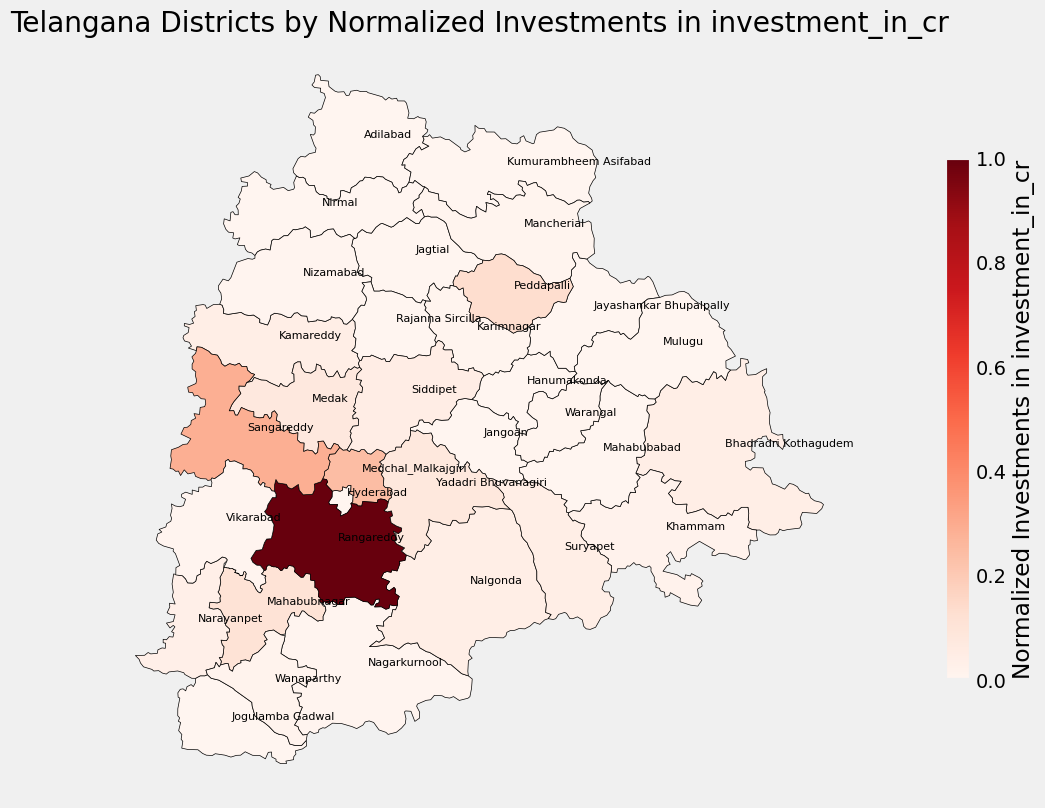

In [26]:
def visualize_district_investments(geo_data, district_investments, column_name, colormap):
    # Extract district and investment data
    data = district_investments[['district', column_name]]
    
    # Apply Min-Max scaling
    scaler = MinMaxScaler()
    data[column_name + '_normalized'] = scaler.fit_transform(data[[column_name]])
    
    # Create a dictionary for mapping
    normalized_investments_dict = dict(zip(data['district'], data[column_name + '_normalized']))
    
    # Normalize the values for color mapping
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Since we've normalized the data, the range is 0 to 1
    
    # Map the district names to their corresponding colors based on normalized investment values
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: colormap(norm(normalized_investments_dict.get(x, 0))))
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, edgecolor="k", facecolor=geo_data['color'])
    
    # Annotate district names
    for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.1)
    cbar.set_label(f'Normalized Investments in {column_name}')
    
    ax.set_title(f"Telangana Districts by Normalized Investments in {column_name}")
    
    # Remove grid lines and axis ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Save the plot as PNG
    save_path = os.path.join("D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8", f"{column_name}_investments_map.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Merge the investment data with the geographical data
geo_data = geo_data.merge(sorted_districts_df, left_on="Dist_Name", right_on="district", how="left")

# Use the function
colormap = plt.cm.Reds  # You can choose any other colormap if you prefer
visualize_district_investments(geo_data, sorted_districts_df, 'investment_in_cr', colormap)

In [27]:
# Sorting the districts by investment in descending order and selecting the top 3
top_districts = district_investments.sort_values(by='investment_in_cr', ascending=False).head(3)
print(top_districts)

              district  investment_in_cr
25          Rangareddy          42706.35
26          Sangareddy          12366.87
16  Medchal_Malkajgiri          10394.57


In [28]:
# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment', 
           x=top_districts['district'], 
           y=top_districts['investment_in_cr'],
           marker=dict(color='blue'))  # Color of the bars
])

# Define the title string
plot_title = "Top 3 Districts with the Most Significant Investments from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='District',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

# Save the plot (modify the path as per your requirements)
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

fig.show()

In [29]:
# Filter the original investments DataFrame to only include the top 3 districts
filtered_data = investments[investments['district'].isin(top_districts['district'])]

# Group by district and fiscal_year, then sum the investments
grouped_data = filtered_data.groupby(['district', 'fiscal_year']).agg({
    'investment_in_cr': 'sum'
}).reset_index()

# Plotting
fig = go.Figure()

# Add a line for each district
for district in top_districts['district']:
    district_data = grouped_data[grouped_data['district'] == district]
    fig.add_trace(go.Scatter(x=district_data['fiscal_year'], 
                             y=district_data['investment_in_cr'], 
                             mode='lines+markers',
                             name=district))

# Define the title string
plot_title = "Yearly Investment Trend for Top 3 Districts from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Fiscal Year',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h')
)

fig.show()

In [30]:
# Grouping by sector and summing the investments
sector_investments = investments.groupby('sector').agg({
    'investment_in_cr': 'sum'
}).reset_index()

# Sorting the sectors by investment in descending order
sorted_sectors = sector_investments.sort_values(by='investment_in_cr', ascending=False)

# Identifying the sector with the highest investment
most_significant_sector = sorted_sectors.iloc[0]['sector']

In [31]:
most_significant_sector

'Real Estate,Industrial Parks and IT Buildings'

In [32]:
# Filtering the data for the identified "most significant sector"
filtered_data = investments[investments['sector'] == most_significant_sector]

# Grouping this filtered data by the 'district' column and summing the investments
district_investments_for_sector = filtered_data.groupby('district').agg({
    'investment_in_cr': 'sum'
}).reset_index()

In [33]:
# Sorting the districts by investment in descending order for the identified sector
sorted_districts_for_sector = district_investments_for_sector.sort_values(by='investment_in_cr', ascending=False)

# Selecting the top 3 districts
top_3_districts = sorted_districts_for_sector.head(3)

print(top_3_districts)

             district  investment_in_cr
2          Rangareddy          28970.28
1  Medchal_Malkajgiri            776.49
3          Sangareddy             20.96


In [34]:
# Colors for the bars
colors = ['lightblue', 'lightgreen', 'red']

# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment in Most Significant Sector', 
           x=top_3_districts['district'], 
           y=top_3_districts['investment_in_cr'],
           marker=dict(color=colors))  # Different color for each bar
])

# Define the title string
plot_title = f"Top 3 Districts with the Most Investments in {most_significant_sector} from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='District',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

fig.show()

## The top 3 districts with the most significant investments during the fiscal years 2019 to 2022 are:

1. Rangareddy: ₹42,706.35 crores
2. Sangareddy: ₹12,366.87 crores
3. Medchal_Malkajgiri: ₹10,394.57 crores

### Factors That Might Have Led to Substantial Investments in These Districts:

- **Infrastructure & Connectivity:** Districts with well-developed infrastructure, including roads, railways, and airports, tend to attract more investments.

- **Proximity to Urban Centers:** Districts close to major cities or business hubs can attract more investments due to easy access to markets and skilled labor.

- **Government Policies:** Favorable government policies, incentives, and ease of doing business can play a significant role in attracting investments.

- **Availability of Resources:** The availability of natural resources, raw materials, or a skilled workforce can be a factor.

- **Existing Industries:** The presence of established industries can attract ancillary units or service providers leading to more investments.

The top 3 districts, Rangareddy, Sangareddy, and Medchal_Malkajgiri, are all situated around the capital city of Hyderabad, which is a major metropolis and a hub for several industries, especially IT, pharma, and biotech. This geographical proximity to Hyderabad plays a crucial role in their investment attraction. Here's a detailed analysis:

1. **Proximity to Hyderabad:**
   - **Business Ecosystem:** Hyderabad has a thriving business ecosystem, which naturally extends to its surrounding districts. Companies prefer to invest in nearby areas where they can still tap into the metropolitan ecosystem without facing the challenges of urban congestion.
   - **Ease of Expansion:** For companies already established in Hyderabad, it's easier to expand into nearby districts than to relocate to distant regions.

2. **Infrastructure & Connectivity:**
   - **Air Connectivity:** The presence of the Rajiv Gandhi International Airport in Hyderabad provides excellent air connectivity, facilitating international business and the movement of goods and services.
   - **Road and Rail:** These districts have well-connected road and rail networks, ensuring smooth transportation.

3. **Skilled Workforce:**
   - **Talent Pool:** Hyderabad boasts numerous premier institutions and universities. Companies in nearby districts can easily tap into this talent pool.
   - **Training and Development:** With several training centers and institutions in and around Hyderabad, companies have the advantage of continuous workforce upskilling.

4. **Real Estate & Development:**
   - **Space Availability:** While Hyderabad might have space constraints and higher real estate prices, surrounding districts offer ample space at competitive rates.
   - **Integrated Townships & SEZs:** Several integrated townships and Special Economic Zones (SEZs) in these districts cater to specific industries, providing state-of-the-art infrastructure and incentives.

5. **Government Initiatives:**
   - **Investment Policies:** The Telangana government has rolled out numerous investor-friendly policies, especially for these regions.
   - **Ease of Doing Business:** The state has made concerted efforts to simplify business regulations and processes, which benefits companies in these districts.

6. **Cluster Development:**
   - **Industry Clusters:** Over time, specific industry clusters have developed in these regions, such as IT in Rangareddy and Pharma in Sangareddy. Such clusters lead to a snowball effect, attracting more companies from the same sector due to shared resources, vendors, and knowledge.

7. **Quality of Life:**
   - **Urban Amenities with Peaceful Living:** These districts offer a balance between urban amenities and a peaceful living environment, making them attractive for employees and therefore employers.

In conclusion, the combination of proximity to Hyderabad, excellent infrastructure, a skilled workforce, and supportive government policies has made Rangareddy, Sangareddy, and Medchal_Malkajgiri top destinations for investments. It's a synergy of location, infrastructure, policy, and talent that converges to create an attractive investment proposition.


### Top 3 Districts with the Most Significant Sector Investment (FY 2019-2022)

#### Most Significant Sector Investment (FY 2019-2022) is Real Estate,Industrial Parks and IT Buildings

1. Rangareddy: ₹42,706.35 crores
2. Sangareddy: ₹12,366.87 crores
3. Medchal_Malkajgiri: ₹10,394.57 crores

## Report:

During the fiscal years 2019 to 2022, Rangareddy emerged as the district with the highest investments, amassing a staggering ₹42,706.35 crores. It is followed by Sangareddy with investments totaling ₹12,366.87 crores. The third spot is occupied by Medchal_Malkajgiri, having attracted ₹10,394.57 crores during the specified period.

These districts, all in close proximity to the metropolitan hub of Hyderabad, have showcased their potential as favorable investment destinations. Their strategic location, coupled with a conducive business environment, has made them the top choices for investors.

For entities looking to invest in the region, these districts clearly stand out as preferred choices, given their track record over the past years. Further, policymakers and local administrations can draw insights from these findings to devise strategies that bolster investment prospects for other districts as well.

## Anomaly:

The "Real Estate, Industrial Parks, and IT Buildings" sector alone attracted a massive ₹23,686.75 crores, which is the primary contributor to the anomaly.

### Contextual Factors:

The exceptionally high investment in the "Real Estate, Industrial Parks, and IT Buildings" sector suggests that there might have been significant infrastructure or real estate development projects in Rangareddy during 2019. This could be attributed to several factors:

- **Government Initiatives:** The Telangana government might have introduced favorable policies or incentives for infrastructure development, promoting real estate projects.

- **Demand for IT Spaces:** Given the booming IT industry in and around Hyderabad, there might have been an increased demand for IT parks and buildings, leading developers to invest heavily in the district.

- **Strategic Location:** Rangareddy's proximity to Hyderabad, the state's capital and a major IT hub, makes it an attractive destination for real estate and infrastructure developers.

- **Economic Climate:** The economic conditions in 2019 might have been conducive to large-scale investments in the district.

## Conclusion:

Rangareddy district saw a substantial investment in 2019, predominantly in the "Real Estate, Industrial Parks, and IT Buildings" sector. This anomaly suggests that there were significant infrastructure or real estate development projects during that year. Factors such as government initiatives, demand for IT infrastructure, the district's strategic location, and favorable economic conditions could have influenced this surge in investments. It would be beneficial to dive deeper into the specific projects and initiatives launched in 2019 in Rangareddy to gain a more comprehensive understanding.


## Note:
From 2019 to 2022, Hyderabad received a total investment of ₹55.8 crores. Given that Hyderabad is the capital city and a major commercial hub of Telangana, this figure appears surprisingly low. This discrepancy might be attributed to various factors, such as data limitations, investment shifts to neighboring districts, or specific policies and developments that directed larger projects outside the central city. A deeper exploration into the investment patterns, sectors, and city's strategic planning during these years would provide clarity on this unexpected trend.




# Problem Statement 11
## Are there any particular sectors that have shown substantial investment in multiple districts between FY 2021 and 2022?

In [35]:
# Filter the Data
filtered_data = investments[investments['fiscal_year'].isin([2021, 2022])]
filtered_data['fiscal_year'].value_counts()

2021    1512
2022    1433
Name: fiscal_year, dtype: int64

In [55]:
#Group and Aggregate
grouped_data = filtered_data.groupby(['sector', 'district']).agg({
    'investment_in_cr': 'sum'
}).reset_index()

grouped_data.head()

sector              district  investment_in_cr
0  Agro based incl Cold Storages              Adilabad              2.04
1  Agro based incl Cold Storages  Bhadradri Kothagudem              3.41
2  Agro based incl Cold Storages           Hanumakonda              0.67
3  Agro based incl Cold Storages               Jagtial             16.87
4  Agro based incl Cold Storages               Jangoan              6.69

In [56]:
grouped_data

sector              district  investment_in_cr
0    Agro based incl Cold Storages              Adilabad              2.04
1    Agro based incl Cold Storages  Bhadradri Kothagudem              3.41
2    Agro based incl Cold Storages           Hanumakonda              0.67
3    Agro based incl Cold Storages               Jagtial             16.87
4    Agro based incl Cold Storages               Jangoan              6.69
..                             ...                   ...               ...
379               Wood and Leather              Siddipet              2.48
380               Wood and Leather              Suryapet              0.08
381               Wood and Leather             Vikarabad              2.44
382               Wood and Leather              Warangal              0.43
383               Wood and Leather   Yadadri Bhuvanagiri              1.02

[384 rows x 3 columns]

In [37]:
grouped_data['sector'].value_counts()

Food Processing                                                                33
Others                                                                         32
Cement, Cement & Concrete Products, Fly Ash Bricks                             32
Agro based incl Cold Storages                                                  31
Engineering                                                                    31
Granite and Stone Crushing                                                     28
Beverages                                                                      26
Plastic and Rubber                                                             25
Pharmaceuticals and Chemicals                                                  25
Wood and Leather                                                               23
Textiles                                                                       22
Paper and Printing                                                             21
Fertlizers Organ

Identifying Sectors with Substantial Investment:

For each sector, identify districts where the investment exceeds a certain threshold (this threshold can be an absolute value or a percentile based on the distribution of investments).

In [38]:
grouped_data['investment_in_cr'].describe()

count     384.000000
mean      113.682057
std       421.082635
min         0.000000
25%         1.020000
50%         5.350000
75%        43.565000
max      4633.170000
Name: investment_in_cr, dtype: float64

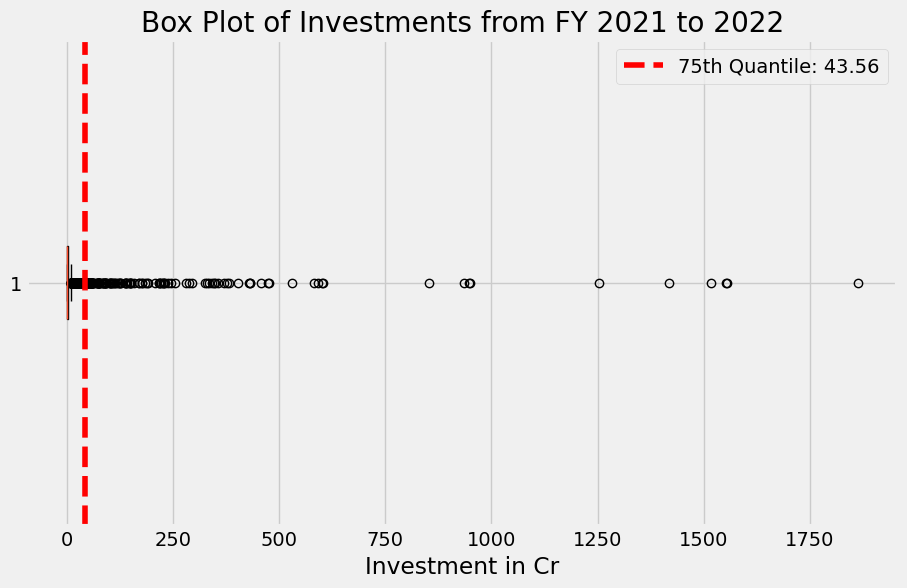

In [39]:
# Calculate the 75th quantile
threshold = grouped_data['investment_in_cr'].quantile(0.75)

# Create a box plot for the 'investment_in_cr' column
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_data['investment_in_cr'], vert=False)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'75th Quantile: {threshold:.2f}')
plt.title("Box Plot of Investments from FY 2021 to 2022")
plt.xlabel('Investment in Cr')
plt.legend()
plt.show()

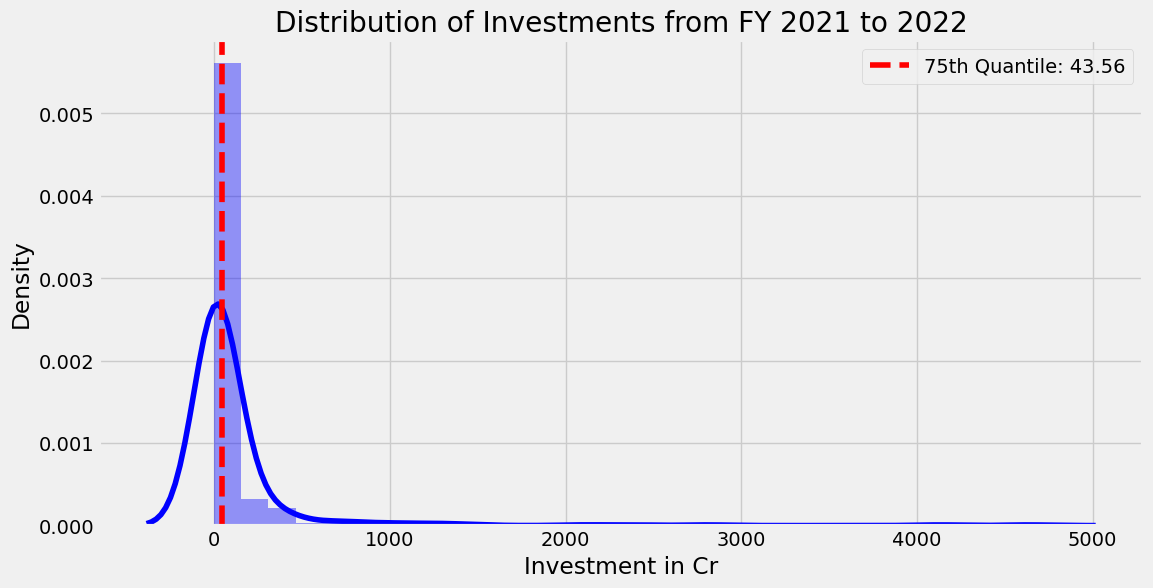

In [40]:
# Create a combined plot of Histogram and KDE for 'investment_in_cr'
plt.figure(figsize=(12, 6))
sns.distplot(grouped_data['investment_in_cr'], bins=30, kde=True, color='blue')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'75th Quantile: {threshold:.2f}')
plt.title("Distribution of Investments from FY 2021 to 2022")
plt.xlabel('Investment in Cr')
plt.ylabel('Density')
plt.legend()
plt.show()

In [41]:
# Count Districts
grouped_data['is_substantial'] = grouped_data['investment_in_cr'] > threshold
sector_counts = grouped_data.groupby('sector')['is_substantial'].sum()

In [42]:
sector_counts

sector
Agro based incl Cold Storages                                                   5
Automobile                                                                      2
Beverages                                                                       5
Cement, Cement & Concrete Products, Fly Ash Bricks                              2
Electrical and Electronic Products                                              4
Engineering                                                                     8
Fertlizers Organic and Inorganic,Pesticides,Insecticides, and Other Related     0
Food Processing                                                                19
Granite and Stone Crushing                                                      5
Industrial Parks and IT Buildings                                               1
Others                                                                          7
Paper and Printing                                                              6
Pharmaceu

In [43]:
significant_sectors = sector_counts[sector_counts >= 3].index.tolist()
significant_sectors

['Agro based incl Cold Storages',
 'Beverages',
 'Electrical and Electronic Products',
 'Engineering',
 'Food Processing',
 'Granite and Stone Crushing',
 'Others',
 'Paper and Printing',
 'Pharmaceuticals and Chemicals',
 'Plastic and Rubber',
 'R&D',
 'Solar and Other Renewable Energy',
 'Textiles']

In [44]:
#  Calculate the 75th percentile of investment values for each sector
thresholds = filtered_data.groupby('sector')['investment_in_cr'].quantile(0.75).reset_index()

#  Merge the thresholds with the original data
merged_data = pd.merge(filtered_data, thresholds, on='sector', how='left', suffixes=('', '_75th'))

#  Filter rows where investment exceeds the sector-specific threshold
substantial_investments = merged_data[merged_data['investment_in_cr'] > merged_data['investment_in_cr_75th']]

#  Count the number of districts with substantial investments for each sector
district_counts = substantial_investments.groupby('sector')['district'].nunique().reset_index()
district_counts.columns = ['sector', 'number_of_districts']

#  Display sectors with substantial investments in multiple districts
district_counts_sorted = district_counts[district_counts['number_of_districts'] > 1].sort_values(by='number_of_districts', ascending=False)
district_counts_sorted


sector  number_of_districts
7                                     Food Processing                   28
3   Cement, Cement & Concrete Products, Fly Ash Br...                   23
0                       Agro based incl Cold Storages                   18
2                                           Beverages                   14
9                                              Others                   12
8                          Granite and Stone Crushing                   12
5                                         Engineering                   10
11                      Pharmaceuticals and Chemicals                   10
16                                           Textiles                    9
17                                   Wood and Leather                    9
10                                 Paper and Printing                    7
4                  Electrical and Electronic Products                    6
12                                 Plastic and Rubber                    6
13                                                R&D                    4
15                   Solar and Other Renewable Energy                    4
6   Fertlizers Organic and Inorganic,Pesticides,In...                    3
1                                          Automobile                    2

In [45]:
# Generate a list of colors for each district
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] * (len(district_counts_sorted) // 10 + 1)  # This will repeat the color list to ensure there's a color for each district
district_counts_sorted = district_counts[district_counts['number_of_districts'] > 1].sort_values(by='number_of_districts', ascending=True)
# Plotting
fig = go.Figure(data=[
    go.Bar(name='Number of Districts', 
           y=district_counts_sorted['sector'], 
           x=district_counts_sorted['number_of_districts'], 
           orientation='h',
           marker=dict(color=colors[:len(district_counts_sorted)]))  # Use only the number of colors needed
])

# Define the title string
plot_title = "Sectors with Substantial Investments in Multiple Districts (FY 2021-2022)"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Number of Districts',
    yaxis_title='Sector',
    template="plotly_dark",
    height=1000,
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

# Save the plot (modify the path as per your requirements)
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

# Display the plot
fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Sectors with Substantial Investments in Multiple Districts (FY 2021-2022).html


# District-wise Analysis of Key Investment Sectors (FY 2021-2022)

## Objective:

Identify sectors consistently attracting substantial investments and understand the district-wise trends for these sectors.

## Methodology:

We used the 75th percentile as a threshold to determine substantial investments for various sectors and then identified the top districts contributing to these investments.

## Findings:

### Food Processing:

- **Top Districts:** Nalgonda, Sangareddy, Rangareddy, Siddipet, Medchal_Malkajgiri.
- **Insights:** The prominence of districts close to Hyderabad, such as Rangareddy and Medchal_Malkajgiri, suggests the influence of urban demand on the food processing sector. Districts like Siddipet and Nalgonda, with their agricultural strength, indicate the importance of adding value to agricultural produce.

### Cement, Cement & Concrete Products, Fly Ash Bricks:

- **Top Districts:** Suryapet, Rangareddy, Medchal_Malkajgiri, Mahabubnagar, Sangareddy.
- **Insights:** The significant investments in districts like Suryapet might be due to the presence of raw materials like limestone. Proximity to developing urban centers and infrastructure projects can also influence investments, as seen in Rangareddy and Medchal_Malkajgiri.

### Agro based incl Cold Storages:

- **Top Districts:** Siddipet, Medchal_Malkajgiri, Khammam, Narayanpet, Sangareddy.
- **Insights:** The need to preserve agricultural output and reduce post-harvest losses drives investments in cold storages. Districts like Siddipet, with strong agricultural activities, lead in this sector. Urban demand and efficient supply chains, especially in districts close to urban centers like Medchal_Malkajgiri, also play a crucial role.

### Beverages:

- **Top Districts:** Narayanpet, Wanaparthy, Sangareddy, Khammam, Vikarabad.
- **Insights:** The availability of clean water sources and local agricultural produce for beverage production can drive investments. The growing urban demand for packaged beverages also influences this sector.

### Granite and Stone Crushing:

- **Top Districts:** Rangareddy, Medchal_Malkajgiri, Mahabubnagar, Karimnagar, Sangareddy.
- **Insights:** Natural granite reserves in districts can be a significant attraction for investments. Additionally, the demand from construction and infrastructure projects, especially in rapidly urbanizing areas, drives the granite and stone crushing industry.

## Conclusions:

- **Geographical Advantages:** Districts with natural resources, such as limestone or granite reserves, tend to attract more investments in related sectors.

- **Urban Influence:** Proximity to urban centers can drive demand, especially in sectors like food processing and beverages. Efficient logistics and infrastructure also play a crucial role.

- **Agricultural Strength:** Districts with a strong agricultural base tend to invest in sectors that add value to agricultural produce, such as food processing and cold storages.

## Recommendations:

- **Skill Development:** Districts can introduce training programs tailored to the booming sectors, equipping the local workforce with relevant skills.

- **Infrastructure Boost:** Enhance transportation, storage, and supply chain infrastructure to further stimulate investments, especially in sectors dependent on efficient logistics.

- **Policy Incentives:** For districts lagging in investments, policy initiatives can be introduced to attract investors to these promising sectors.

- **Research & Development:** Encourage R&D in these sectors to drive innovation, enhance product quality, and diversify product ranges.


# Problem Statement 12
## Can we identify any seasonal patterns or cyclicality in the investment trends for specific sectors? Do certain sectors experience higher investments during particular months?

In [46]:
# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\12"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# List of unique sectors
sectors = investments['sector'].unique()

for sector in sectors:
    # Filter data for the current sector
    sector_data = investments[investments['sector'] == sector]
    
    # Create the line plot
    fig = go.Figure()

    # Add trace for investment trends
    fig.add_trace(go.Scatter(x=sector_data['month'], 
                             y=sector_data['investment_in_cr'], 
                             mode='lines+markers',
                             name=f"Investment in {sector}",
                             line=dict(width=2)))
    
    # Update layout
    fig.update_layout(title=f"Investment Trends for {sector}",
                      xaxis_title='Month',
                      yaxis_title='Investment (in Cr)',
                      template="plotly_dark",
                      legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

    # Display the figure
    fig.show()

    # Save the figure as HTML
    fig.write_html(os.path.join(save_dir, f"{sector}_investment_trends.html"))

In [47]:
# Directory to save monthly plots
save_dir_monthly = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\12\\monthly"

# Ensure the directory exists
if not os.path.exists(save_dir_monthly):
    os.makedirs(save_dir_monthly)

# List of unique sectors
sectors = investments['sector'].unique()

# Define the desired order for months
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for sector in sectors:
    # Filter data for the current sector
    sector_data = investments[investments['sector'] == sector]
    
    # Extract month from the 'month' column
    sector_data['month_name'] = pd.to_datetime(sector_data['month']).dt.strftime('%b')
    
    # Convert the 'month_name' column to a categorical type with a specified order
    sector_data['month_name'] = pd.Categorical(sector_data['month_name'], categories=months_order, ordered=True)
    
    # Group by the extracted month and sum the investments
    monthly_sum = sector_data.groupby('month_name').sum()['investment_in_cr'].reset_index()
    
    # Create the line plot
    fig = go.Figure()

    # Add trace for monthly summed investment trends
    fig.add_trace(go.Scatter(x=monthly_sum['month_name'], 
                             y=monthly_sum['investment_in_cr'], 
                             mode='lines+markers',
                             name=f"Investment in {sector}",
                             line=dict(width=2, color='red')))
    
    # Update layout
    fig.update_layout(title=f"Monthly Investment Trends for {sector}",
                      xaxis_title='Month',
                      yaxis_title='Investment (in Cr)',
                      template="plotly_dark",
                      legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

    # Display the figure
    fig.show()

    # Save the figure as HTML
    fig.write_html(os.path.join(save_dir_monthly, f"{sector}_monthly_investment_trends.html"))


### Seasonal Investment Analysis Report

#### Agro based incl Cold Storages:

- **High Investment Months:** March, June
- **Low Investment Months:** January, February, August, October, November

#### Automobile:

- **High Investment Months:** January
- **Low Investment Months:** None observed

#### Beverages:

- **High Investment Months:** January, February, November
- **Low Investment Months:** March, April, June, July, August, September

#### Cement, Cement & Concrete Products, Fly Ash Bricks:

- **High Investment Months:** June, August
- **Low Investment Months:** January, September, October, December

#### Electrical and Electronic Products:

- **High Investment Months:** January, July
- **Low Investment Months:** May, August, October, November, December

#### Engineering:

- **High Investment Months:** February, October
- **Low Investment Months:** January, April, June, July, September

#### Fertilizers Organic and Inorganic, Pesticides, Insecticides, and Other Related:

- **High Investment Months:** December
- **Low Investment Months:** None observed

#### Food Processing:

- **High Investment Months:** March, September, November, December
- **Low Investment Months:** January, April, June, August

#### Granite and Stone Crushing:

- **High Investment Months:** May, June, October
- **Low Investment Months:** February, March, July, August, September, December

#### Industrial Parks and IT Buildings:

- **High Investment Months:** None observed
- **Low Investment Months:** None observed

#### Others:

- **High Investment Months:** June, July, December
- **Low Investment Months:** April, May, September, October, November

#### Paper and Printing:

- **High Investment Months:** July, November
- **Low Investment Months:** April, May, June, September, October

#### Pharmaceuticals and Chemicals:

- **High Investment Months:** February, July, September, December
- **Low Investment Months:** March, April, May, October, November

#### Plastic and Rubber:

- **High Investment Months:** January, August, December
- **Low Investment Months:** February, May, July, October, November

#### R&D:

- **High Investment Months:** February, March, April, September
- **Low Investment Months:** August, October, November, December

#### Real Estate, Industrial Parks, and IT Buildings:

- **High Investment Months:** February
- **Low Investment Months:** June

#### Solar and Other Renewable Energy:

- **High Investment Months:** April, June, November
- **Low Investment Months:** February, March, May, August, October, December

#### Textiles:

- **High Investment Months:** September
- **Low Investment Months:** None observed

#### Thermal Power Plant:

- **High Investment Months:** None observed
- **Low Investment Months:** None observed

#### Wood and Leather:

- **High Investment Months:** January, September
- **Low Investment Months:** March, April, May, October

This report provides insights into the months when specific sectors tend to receive higher or lower investments than average. By understanding these seasonal patterns


In [48]:
# Directory to save quarterly plots
save_dir_quarterly = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\12\\quarterly"

# Ensure the directory exists
if not os.path.exists(save_dir_quarterly):
    os.makedirs(save_dir_quarterly)

for sector in sectors:
    # Filter data for the current sector
    sector_data = investments[investments['sector'] == sector]
    
    # Group by quarter and sum the investments
    quarterly_data = sector_data.groupby('quarter').sum()['investment_in_cr'].reset_index()
    
    # Create the line plot
    fig = go.Figure()

    # Add trace for quarterly investment trends
    fig.add_trace(go.Scatter(x=quarterly_data['quarter'], 
                             y=quarterly_data['investment_in_cr'], 
                             mode='lines+markers',
                             name=f"Investment in {sector}",
                             line=dict(width=2, color='#00CC96')))
    
    # Update layout
    fig.update_layout(title=f"Quarterly Investment Trends for {sector}",
                      xaxis_title='Quarter',
                      yaxis_title='Investment (in Cr)',
                      template="plotly_dark",
                      legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

    # Display the figure
    fig.show()

    # Save the figure as HTML
    fig.write_html(os.path.join(save_dir_quarterly, f"{sector}_quarterly_investment_trends.html"))


In [49]:
# Group by 'sector' and 'month' and sum the 'investment_in_cr'
grouped_data = investments.groupby(['sector', 'month']).sum()['investment_in_cr'].reset_index()

# Convert 'month' to datetime format for further processing
grouped_data['month'] = pd.to_datetime(grouped_data['month'])


In [50]:
# Extract month name from the 'month' column
investments['month_name'] = pd.to_datetime(investments['month']).dt.strftime('%B')

# Define the desired month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Group by month_name, sector, and fiscal_year
grouped = investments.groupby(['month_name', 'sector', 'fiscal_year']).sum()['investment_in_cr'].reset_index()

# Pivot the data
def pivot_data(df, sector_name):
    sector_df = df[df['sector'] == sector_name]
    return sector_df.pivot(index='month_name', columns='fiscal_year', values='investment_in_cr').reindex(month_order)

# Function to plot Year-over-Year data and save as HTML
def plot_yoy_save(pivot_data, sector_name):
    fig = go.Figure()
    for year in pivot_data.columns:
        fig.add_trace(go.Scatter(x=pivot_data.index, 
                                 y=pivot_data[year], 
                                 mode='lines+markers',
                                 name=str(year)))
    fig.update_layout(title=f'Year-over-Year Investment Trends for {sector_name}',
                      xaxis_title='Month',
                      yaxis_title='Investment in Cr',
                      template="plotly_dark",
                      legend=dict(y=-0.3, x=0.4, xanchor='center', orientation='h'))
    
    # Save the plot as HTML
    save_path = os.path.join("D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\12", f"{sector_name}_yoy.html")
    fig.write_html(save_path)
    fig.show()

# Plot and save Year-over-Year for each sector
for sector in investments['sector'].unique():
    pivot_sector = pivot_data(grouped, sector)
    plot_yoy_save(pivot_sector, sector)

Time Series Decomposition

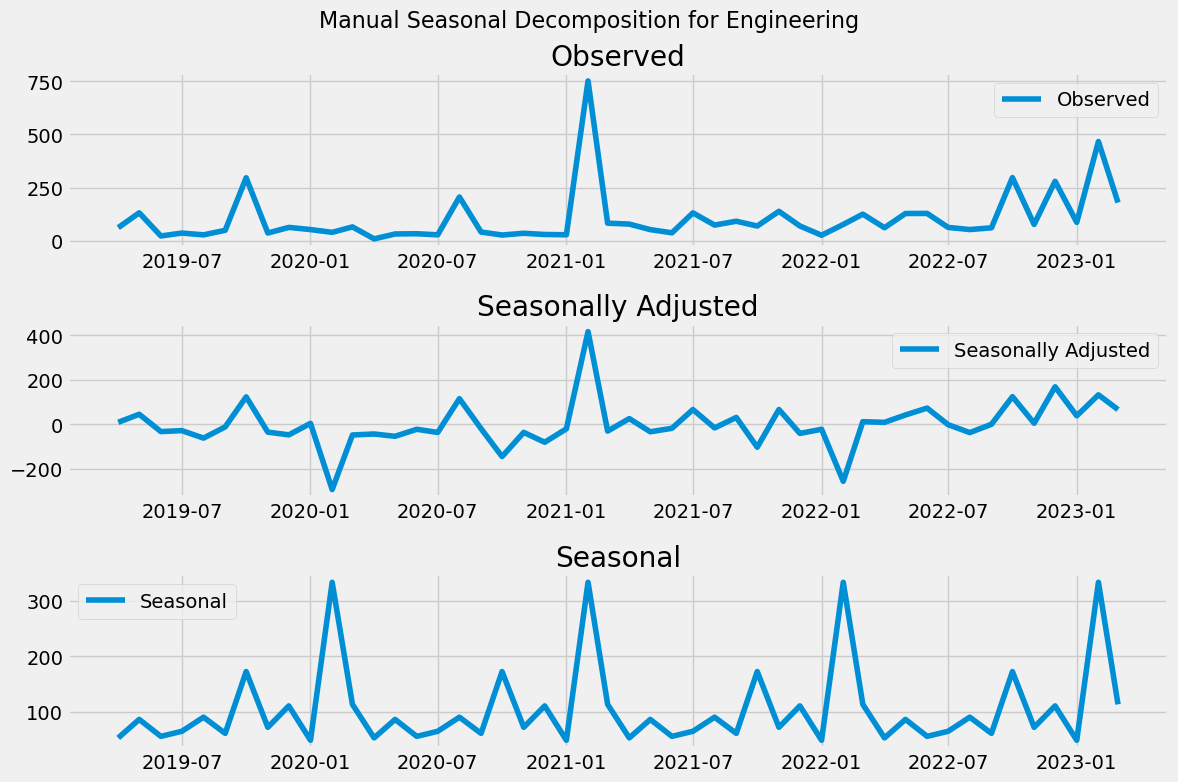

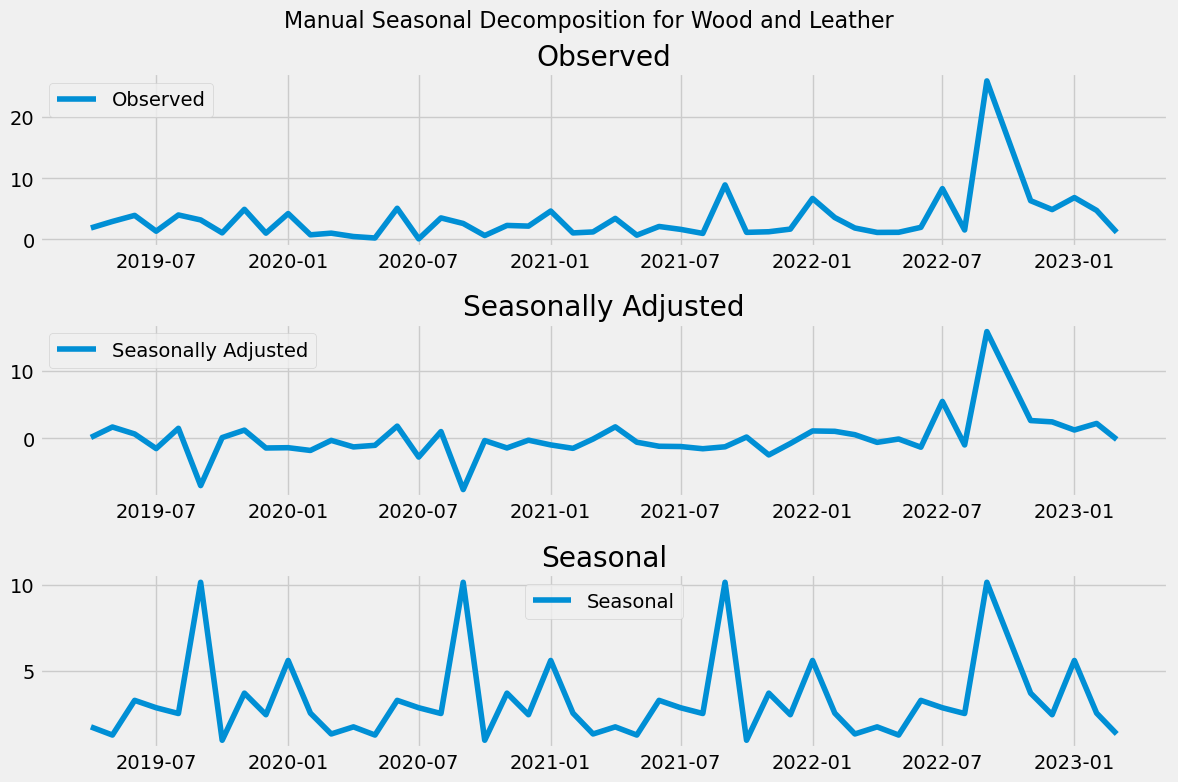

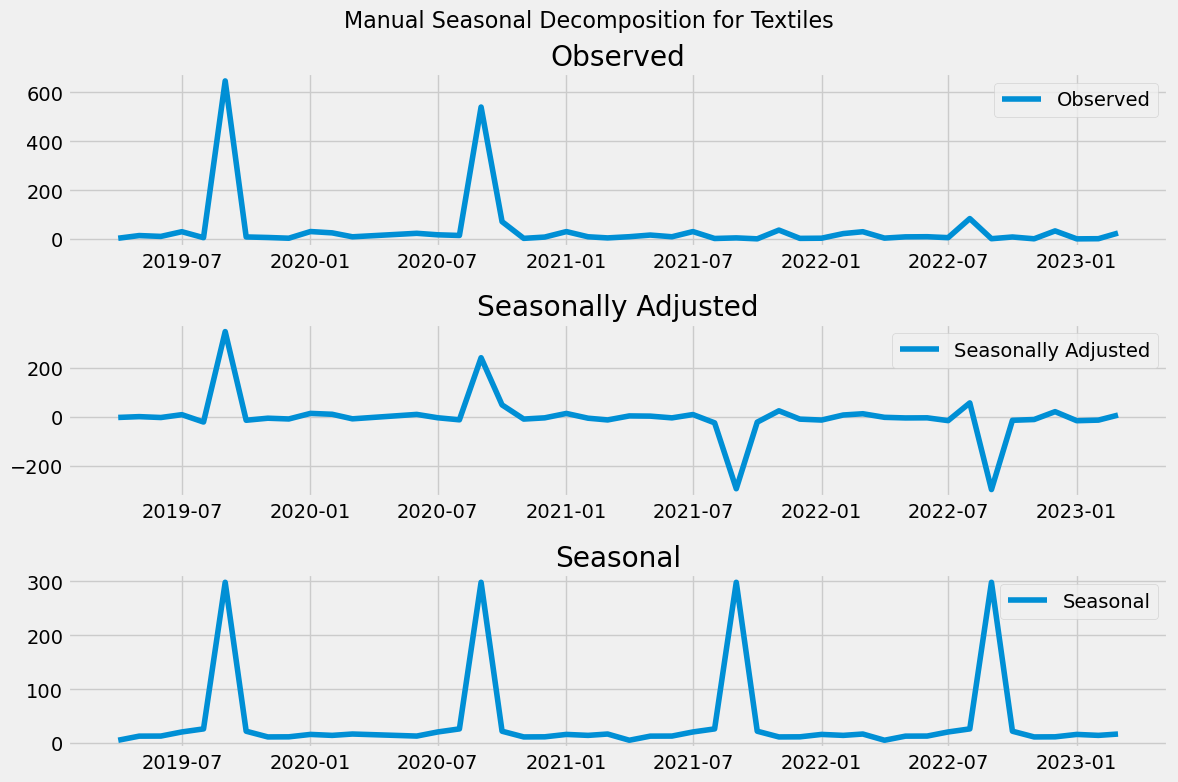

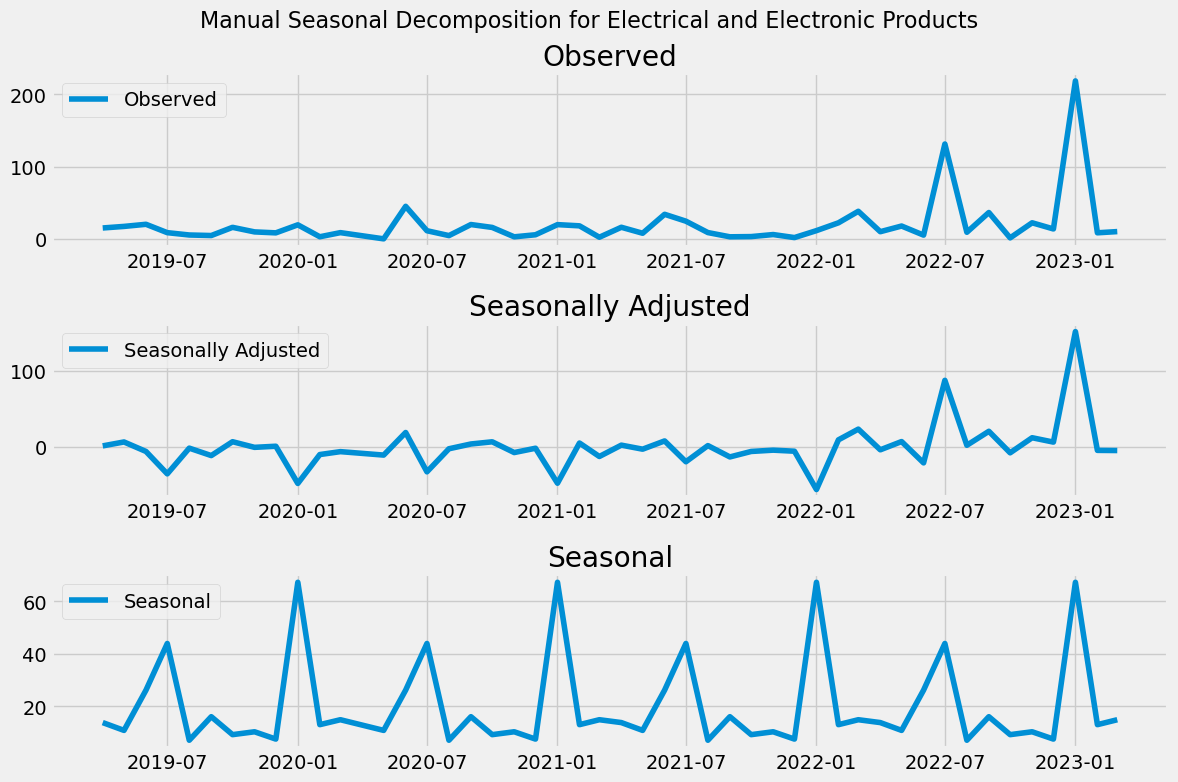

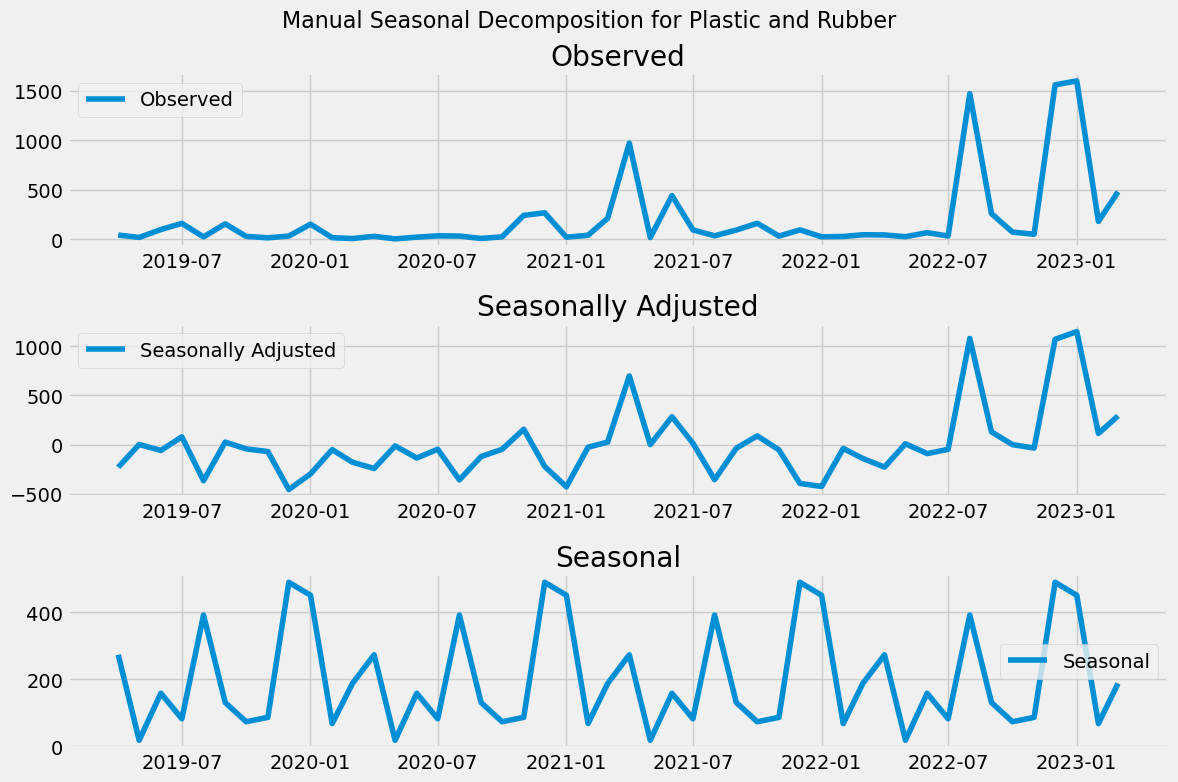

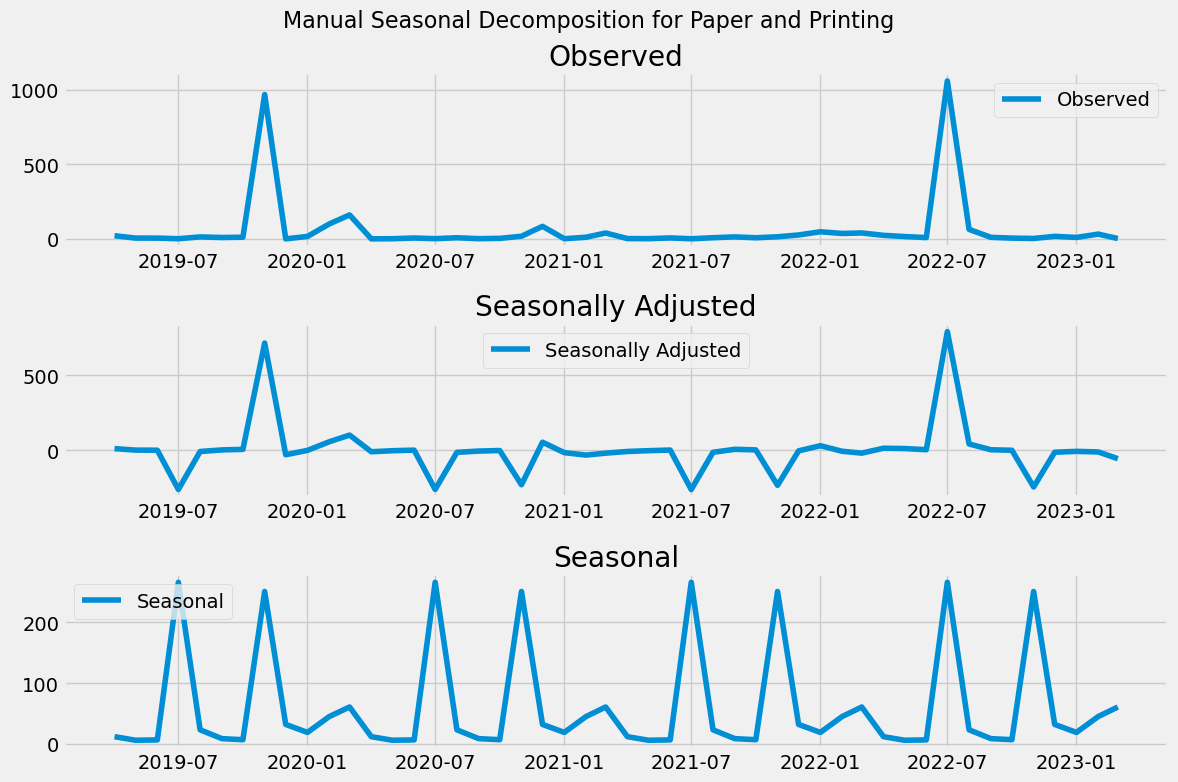

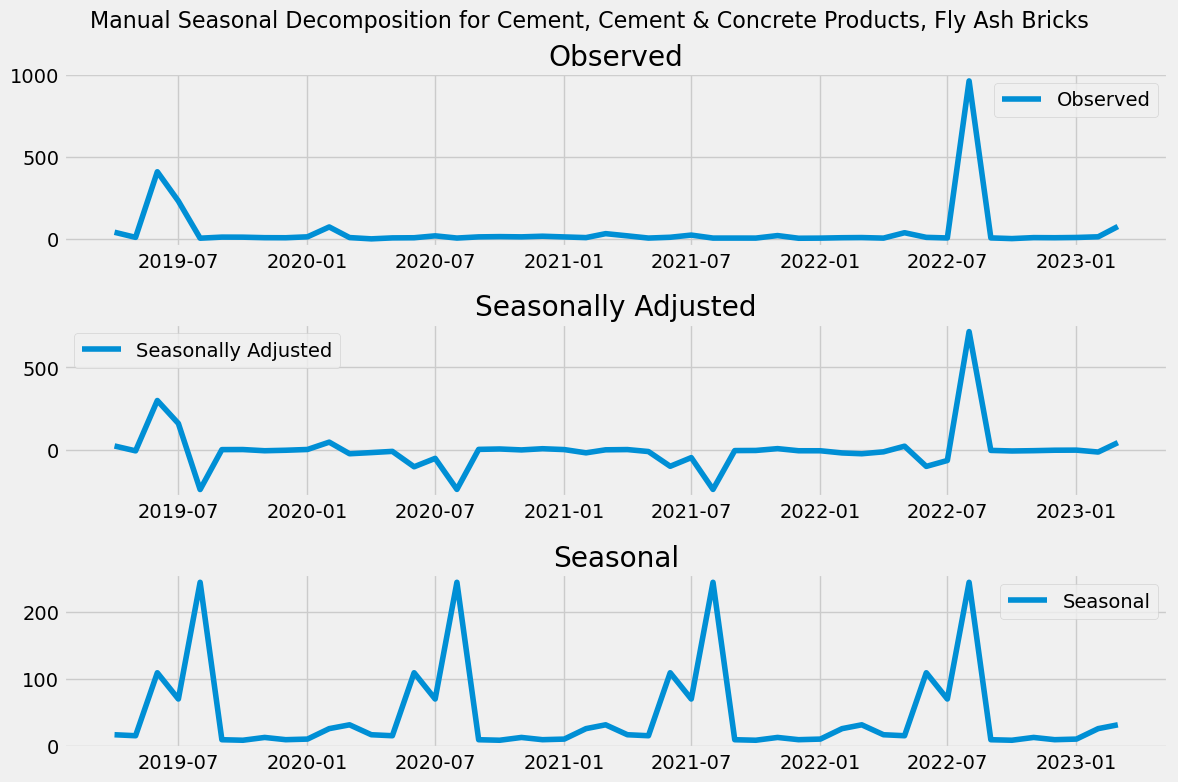

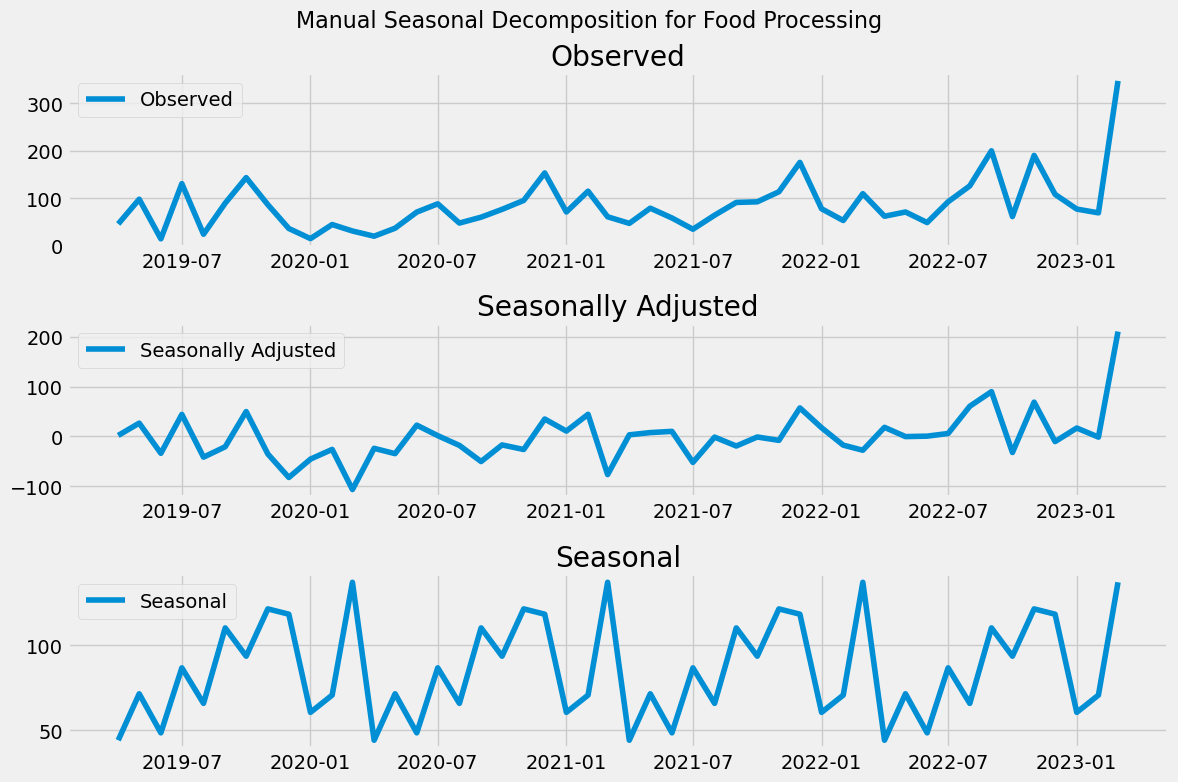

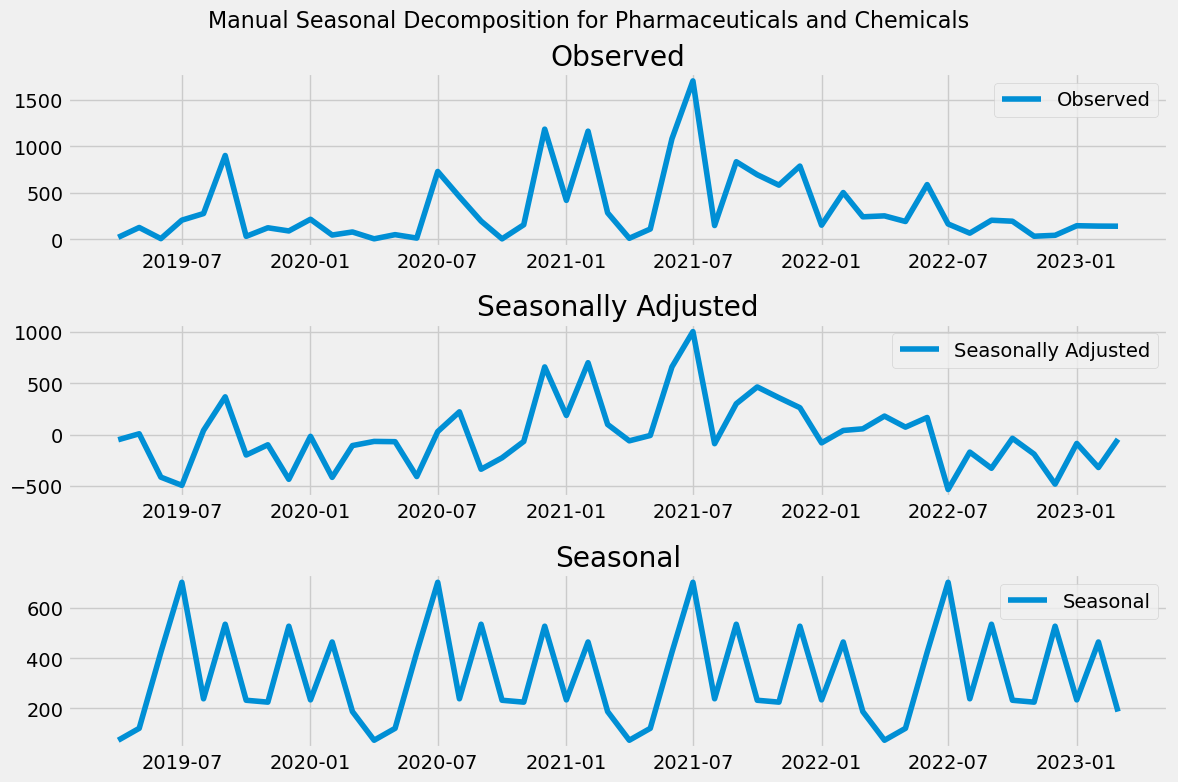

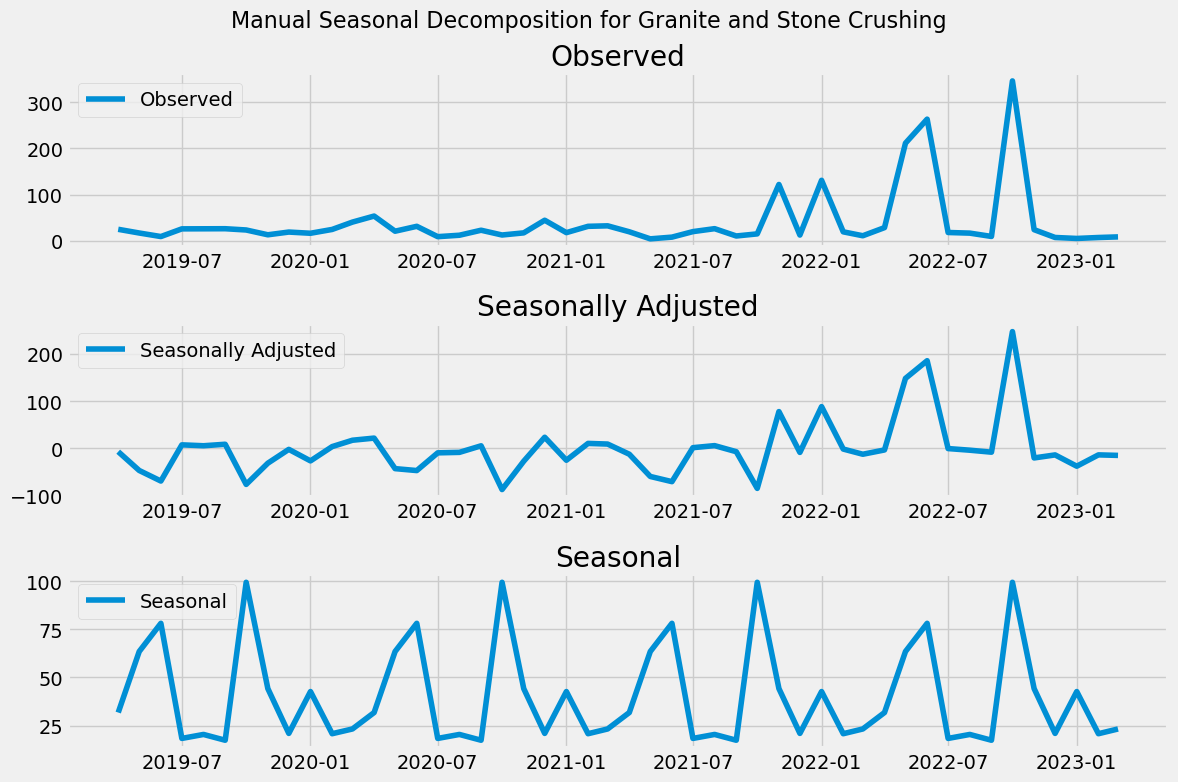

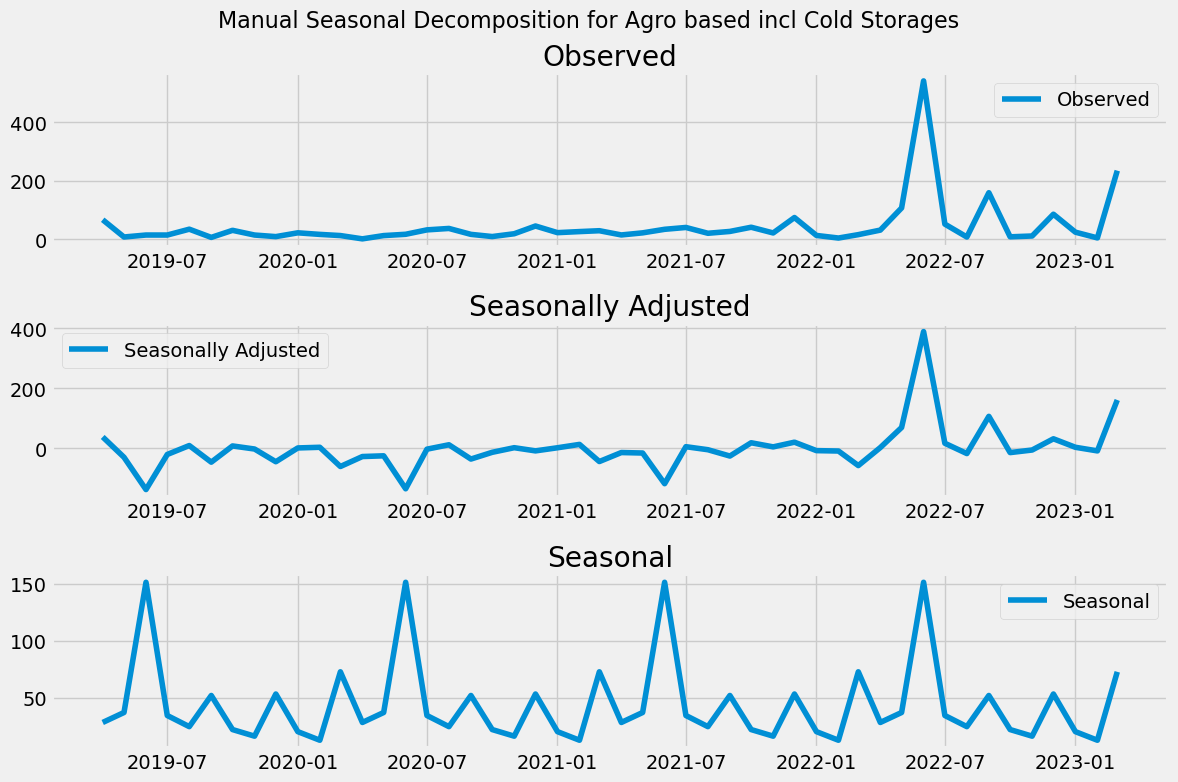

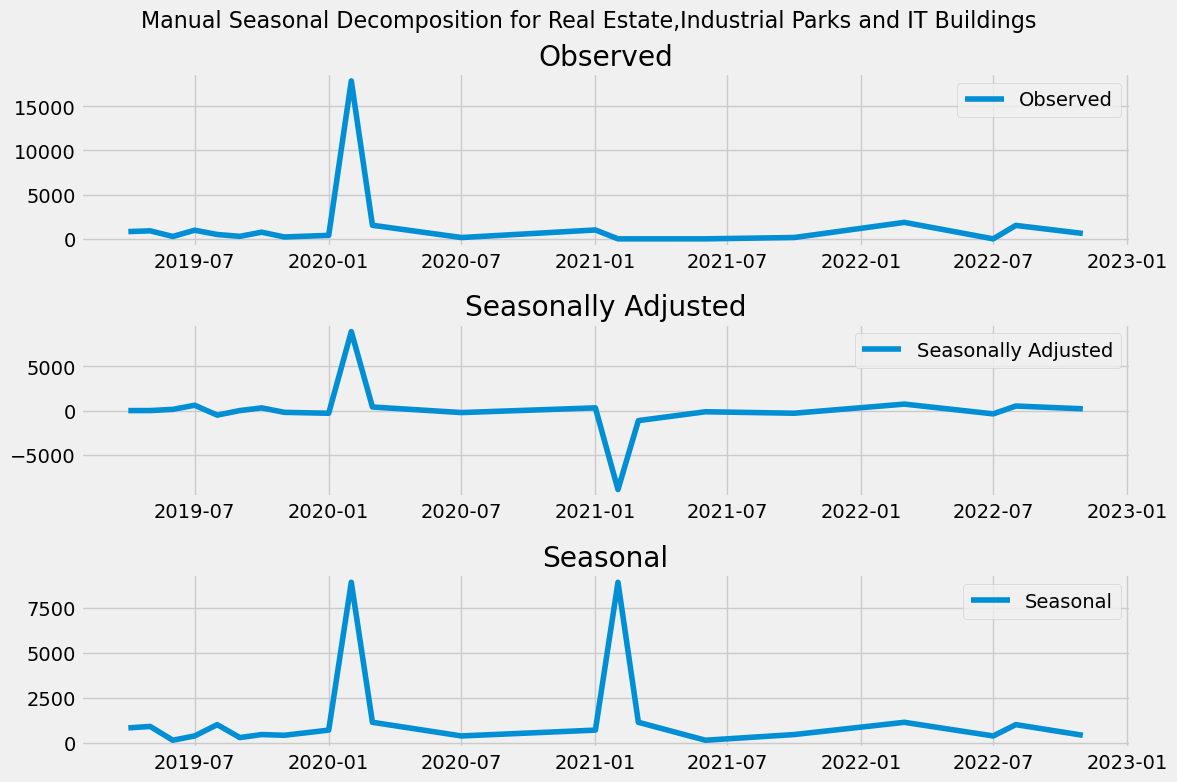

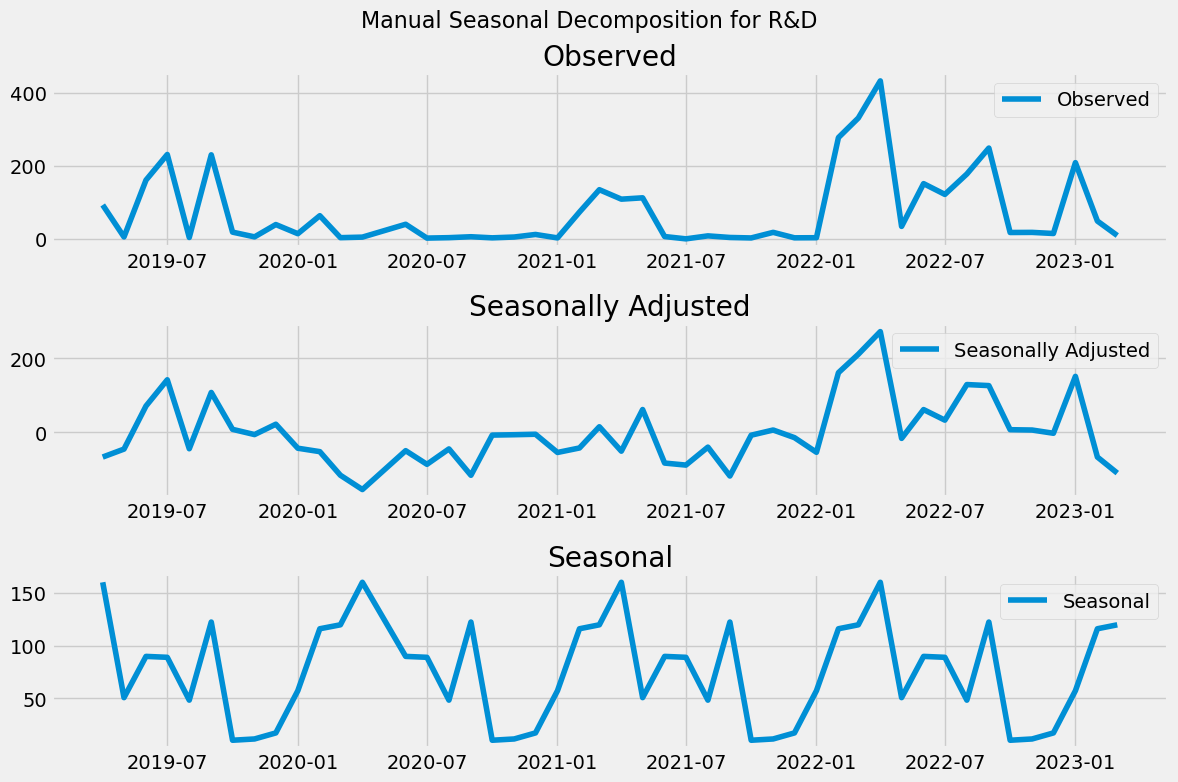

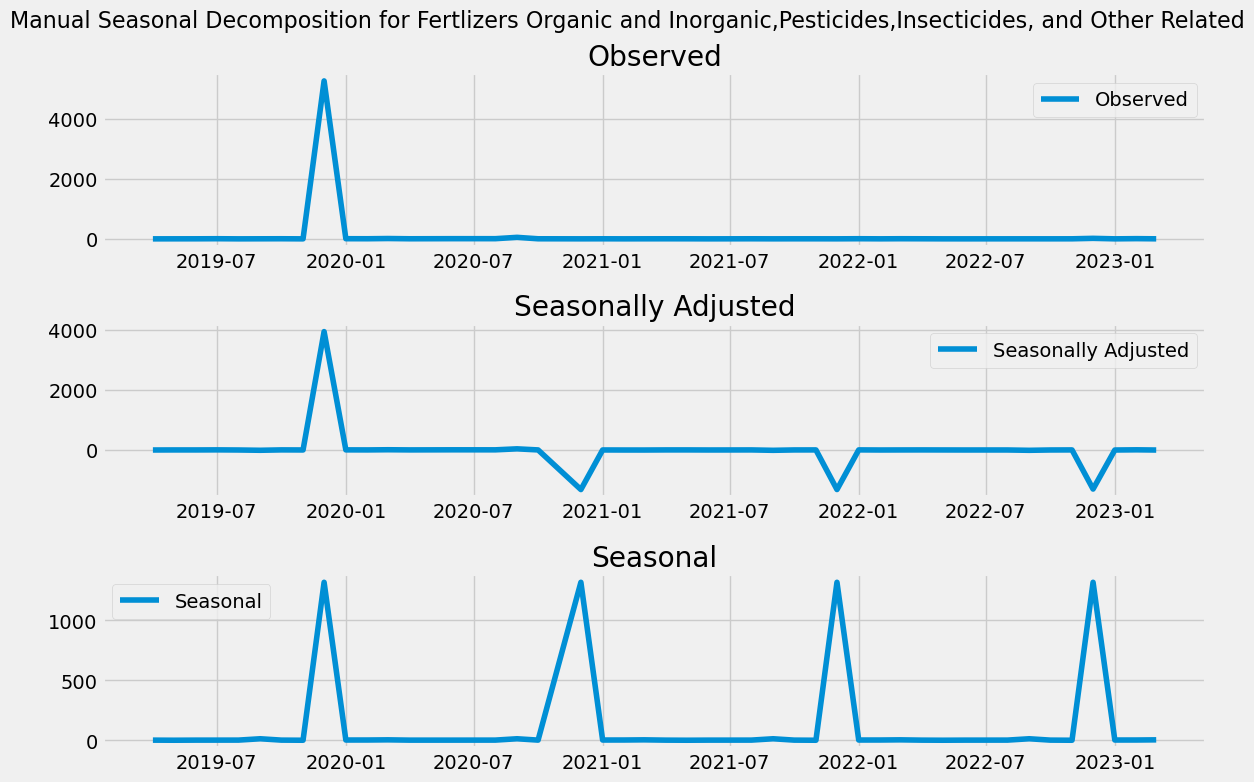

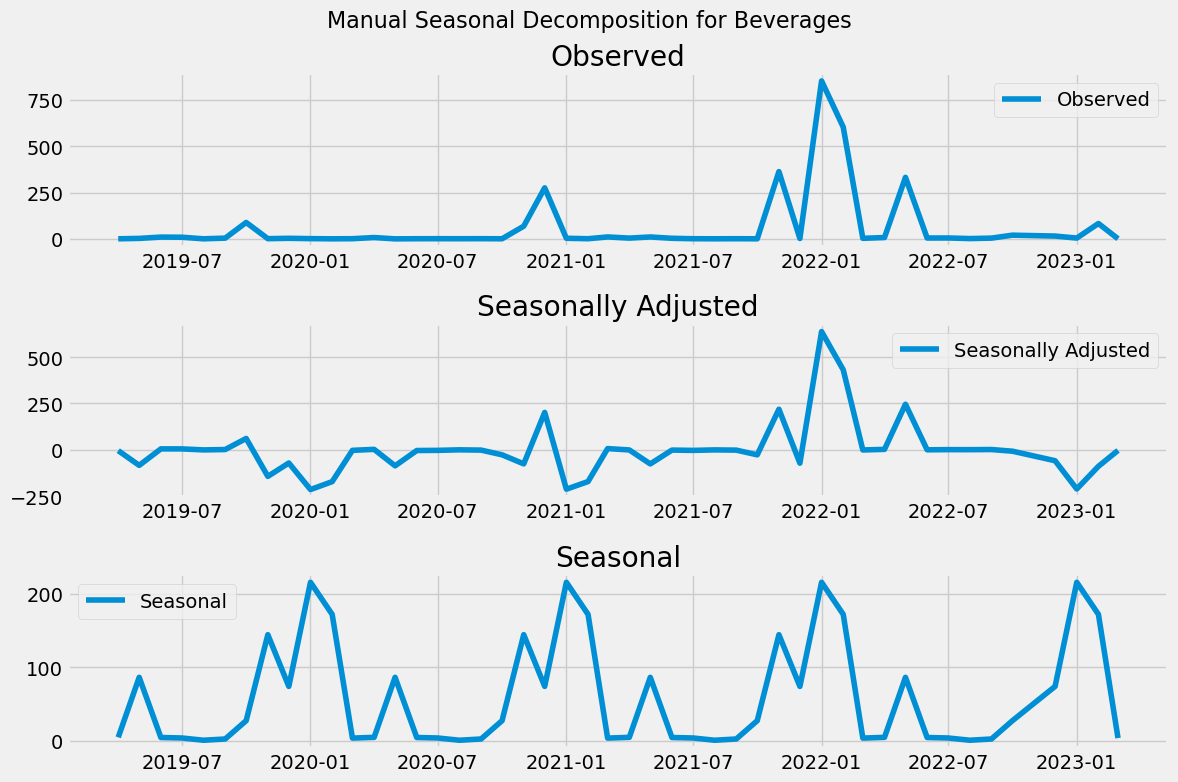

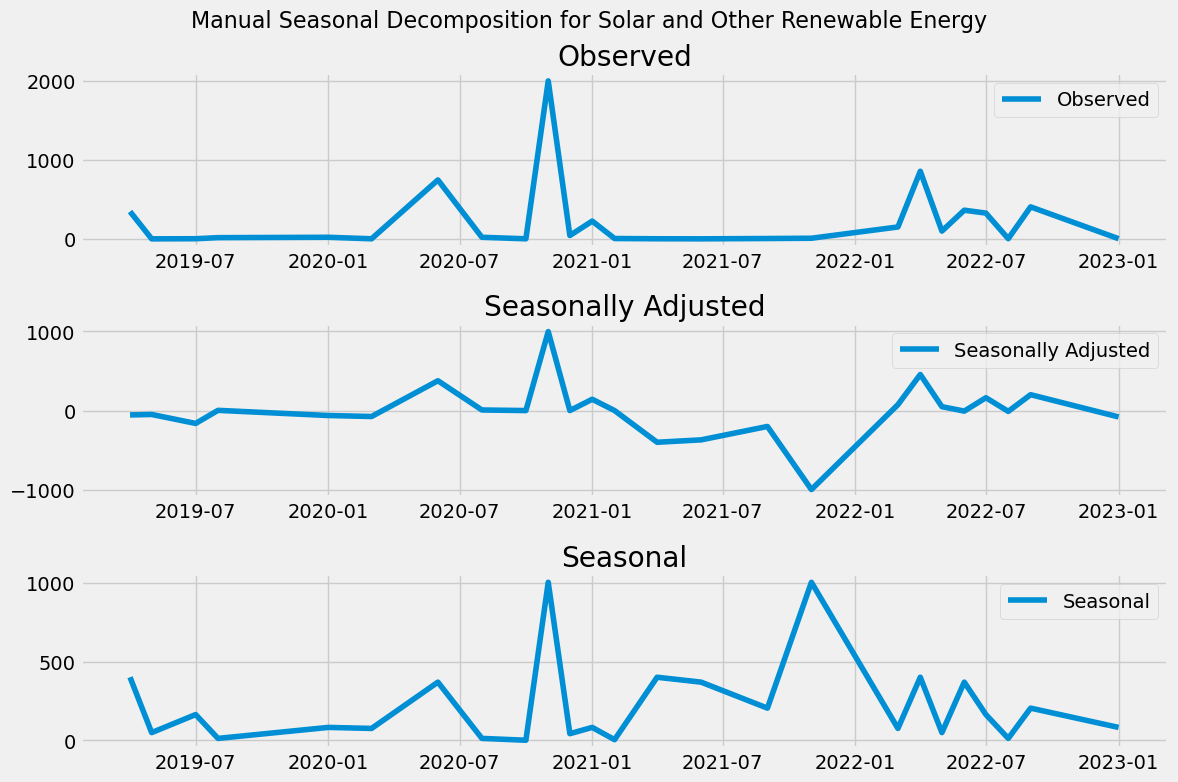

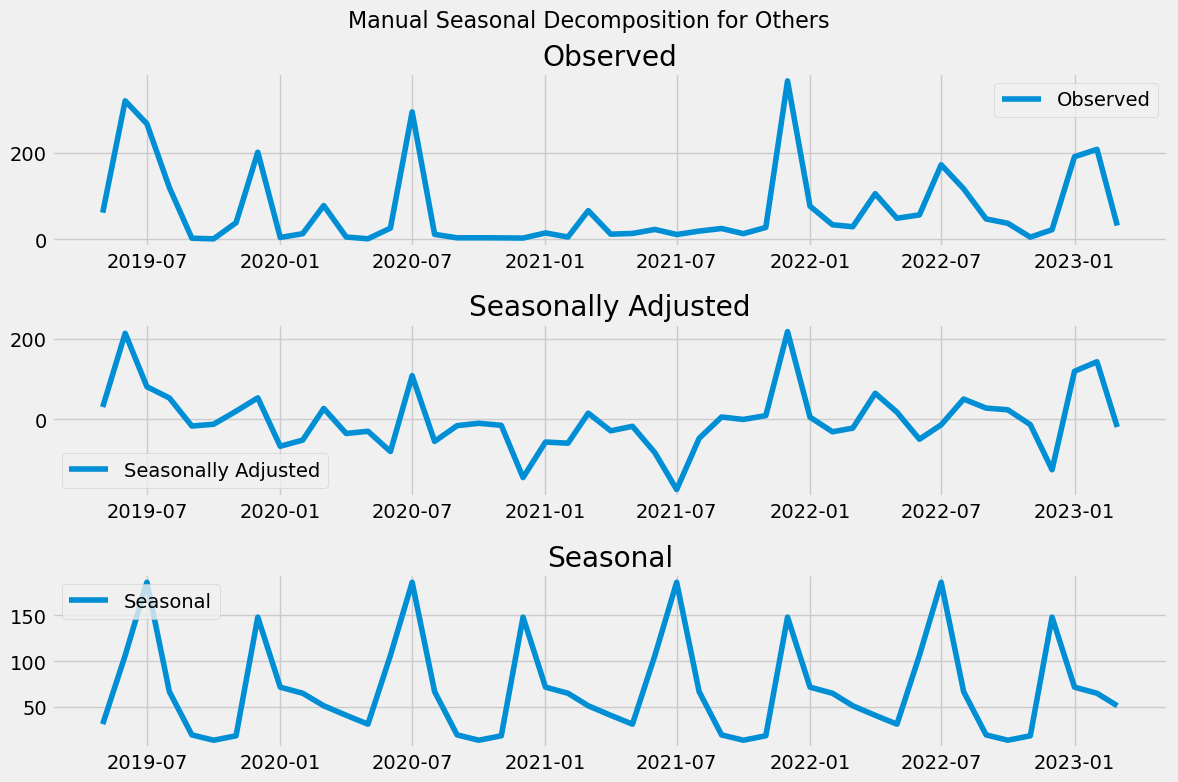

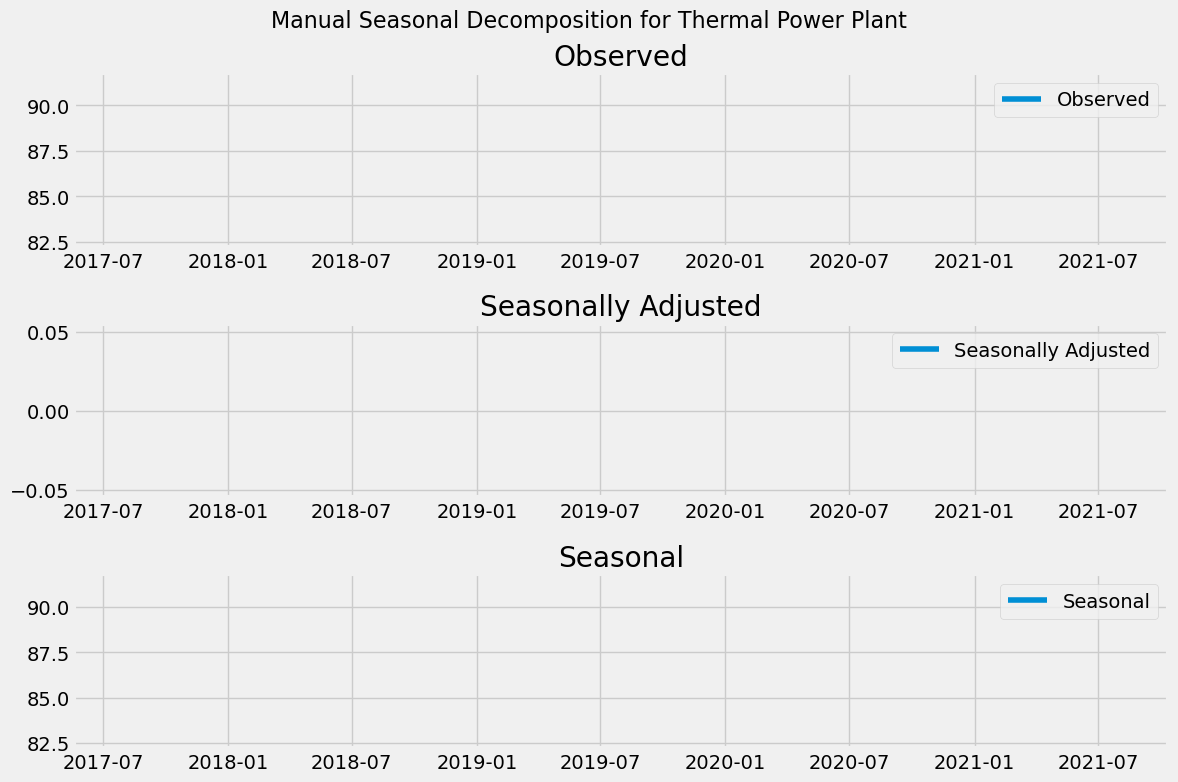

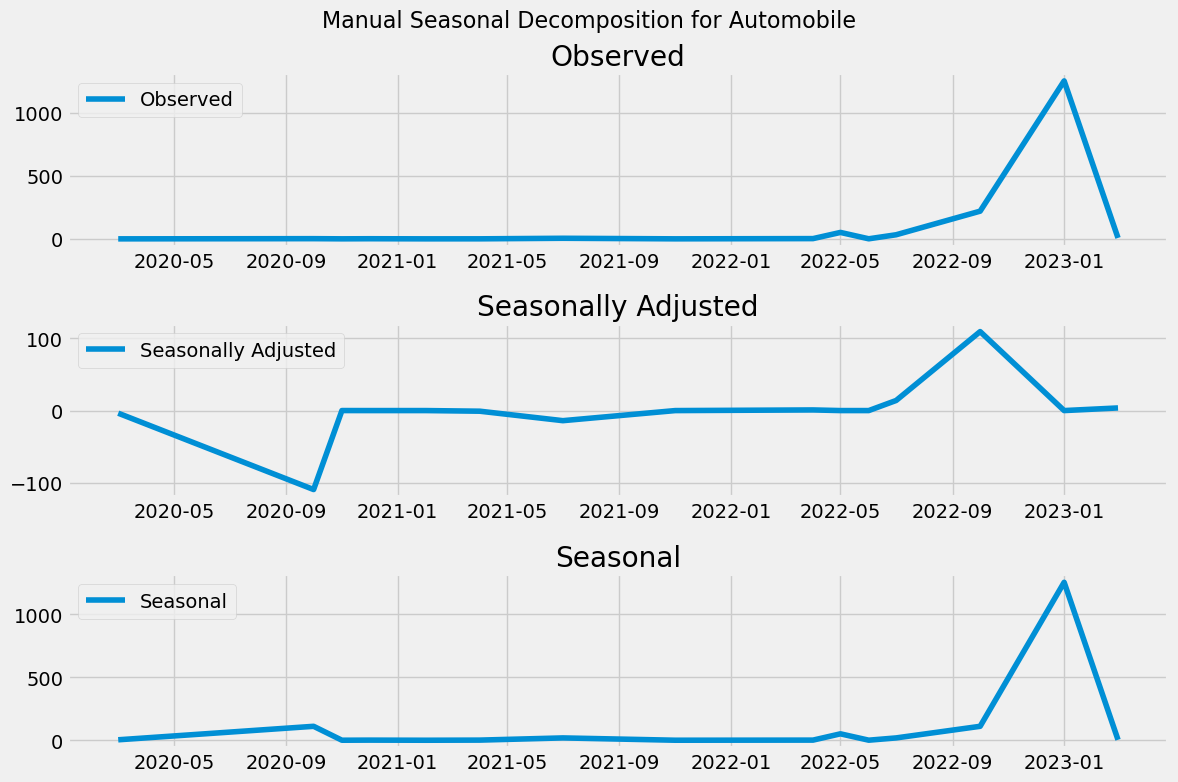

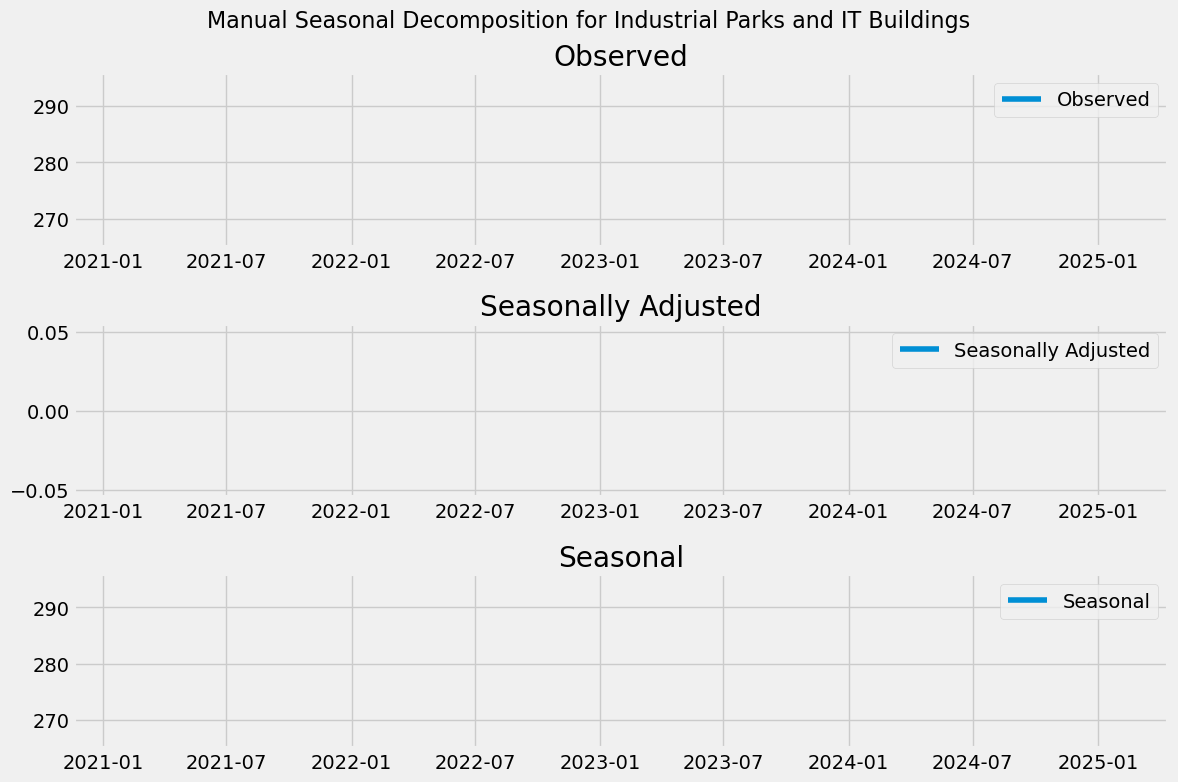

In [51]:
import matplotlib.pyplot as plt

def manual_seasonal_decomposition(sector_data, sector_name):
    # Compute the average monthly investment
    sector_data['month_num'] = sector_data.index.month
    monthly_avg = sector_data.groupby('month_num')['investment_in_cr'].mean()
    
    # Map the average monthly investment back to the original data
    sector_data['seasonal'] = sector_data['month_num'].map(monthly_avg)
    
    # Compute the seasonally adjusted data
    sector_data['seasonally_adjusted'] = sector_data['investment_in_cr'] - sector_data['seasonal']
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Manual Seasonal Decomposition for {sector_name}', fontsize=16)
    
    plt.subplot(3, 1, 1)
    plt.plot(sector_data['investment_in_cr'], label='Observed')
    plt.title('Observed')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(sector_data['seasonally_adjusted'], label='Seasonally Adjusted')
    plt.title('Seasonally Adjusted')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(sector_data['seasonal'], label='Seasonal')
    plt.title('Seasonal')
    plt.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Decompose time series for each sector using the manual approach
for sector in sectors:
    sector_data = grouped_data[grouped_data['sector'] == sector][['month', 'investment_in_cr']]
    
    # Set the month as the index
    sector_data.set_index('month', inplace=True)
    sector_data.index = pd.to_datetime(sector_data.index)
    
    manual_seasonal_decomposition(sector_data, sector)


### Report: Sectors with Seasonal Investment Patterns

### Methodology:

To identify sectors with seasonal patterns, we performed a manual decomposition of the investment data. This involved computing the average monthly investments across years and comparing it to the actual monthly investments. A significant deviation from the average indicates a potential seasonal pattern.

### Assumptions:

- Consistent patterns over multiple years indicate seasonality.
- Only sectors with notable peaks or troughs in the seasonal component were considered. Minor fluctuations were treated as noise.
- The overall market condition or external factors affecting all sectors equally were not considered in this analysis.

### Findings:

#### Agro based incl Cold Storages:

- **Peak Investment Months:** March, June
- **Reason:** Agricultural activities are often seasonal, and investments might be timed to coincide with planting or harvesting periods.

#### Beverages:

- **Peak Investment Months:** January, February, November
- **Reason:** The peaks might coincide with the preparation for summer demand (production ramp-up) and year-end festivities.

#### Cement, Cement & Concrete Products, Fly Ash Bricks:

- **Peak Investment Months:** June, August
- **Reason:** Infrastructure and construction activities might have specific seasonal demands leading to these peaks.

#### Electrical and Electronic Products:

- **Peak Investment Months:** January, July
- **Reason:** Potential release cycles for new products or technology updates.

#### Food Processing:

- **Peak Investment Months:** March, September, November, December
- **Reason:** Aligning with agricultural harvest seasons and year-end holiday demands.

#### Granite and Stone Crushing:

- **Peak Investment Months:** May, June, October
- **Reason:** Construction and infrastructure development seasonality.

#### Others:

- **Peak Investment Months:** June, July, December
- **Reason:** Broad category, but peaks might align with fiscal year-end or mid-year business strategies.

#### Paper and Printing:

- **Peak Investment Months:** July, November
- **Reason:** Increased demand for printing due to academic cycles or year-end documentation.

#### Pharmaceuticals and Chemicals:

- **Peak Investment Months:** February, July, September, December
- **Reason:** Coinciding with global health events or release of new products.

#### Plastic and Rubber:

- **Peak Investment Months:** January, August, December
- **Reason:** Peaks might align with production cycles or year-end demands.

#### Solar and Other Renewable Energy:

- **Peak Investment Months:** April, June, November
- **Reason:** Aligning with seasons where energy production is optimal.

#### Wood and Leather:

- **Peak Investment Months:** January, September
- **Reason:** Peaks might coincide with fashion cycles or furniture production schedules.

### Conclusions:

Certain sectors display clear seasonal patterns in investments. These patterns might be driven by various factors like production cycles, harvest seasons, consumer demand, or business strategies. Recognizing these patterns provides valuable insights for investors, policymakers, and businesses. Proper timing of investments can lead to maximized returns and optimized resource utilization.


In [52]:
import plotly.graph_objects as go
import os

def manual_seasonal_decomposition(sector_data, sector_name, save_dir):
    # Compute the average monthly investment
    sector_data['month_num'] = sector_data.index.month
    monthly_avg = sector_data.groupby('month_num')['investment_in_cr'].mean()
    
    # Map the average monthly investment back to the original data
    sector_data['seasonal'] = sector_data['month_num'].map(monthly_avg)
    
    # Compute the seasonally adjusted data
    sector_data['seasonally_adjusted'] = sector_data['investment_in_cr'] - sector_data['seasonal']
    
    # Create the plot using Plotly
    fig = go.Figure()
    
    # Add traces for observed, seasonally adjusted, and seasonal data
    fig.add_trace(go.Scatter(x=sector_data.index, y=sector_data['investment_in_cr'], mode='lines', name='Observed', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=sector_data.index, y=sector_data['seasonally_adjusted'], mode='lines', name='Seasonally Adjusted', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=sector_data.index, y=sector_data['seasonal'], mode='lines', name='Seasonal', line=dict(color='green')))
    
    # Update layout
    fig.update_layout(title=f'Manual Seasonal Decomposition for {sector_name}', template="plotly_dark")
    
    # Display the figure
    fig.show()
    
    # Save the figure as HTML
    fig.write_html(os.path.join(save_dir, f"{sector_name}_manual_decomposition.html"))

# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\12"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Decompose time series for each sector using the manual approach
for sector in sectors:
    sector_data = grouped_data[grouped_data['sector'] == sector][['month', 'investment_in_cr']]
    
    # Set the month as the index
    sector_data.set_index('month', inplace=True)
    sector_data.index = pd.to_datetime(sector_data.index)
    
    manual_seasonal_decomposition(sector_data, sector, save_dir)


# Report: Sectors with Seasonal Investment Patterns

## Methodology:

To identify sectors with seasonal patterns, a detailed decomposition of the investment data was conducted. This involved calculating the average monthly investments over the years and comparing them to the actual monthly investments. A significant deviation from this average was considered indicative of potential seasonal patterns.

## Assumptions:

- Patterns consistent over multiple years were taken as indicative of seasonality.
- Sectors with significant peaks or troughs in their seasonal components were highlighted. Minor fluctuations were dismissed as noise.
- Broader market conditions or external factors that might influence all sectors uniformly were not taken into account in this analysis.

## Key Findings:

### Seasonal Peaks:

#### Agro-based incl Cold Storages:

- **Peak Investment Months:** March, June
- **Reason:** Aligns with the agricultural calendar, where investments are likely timed with planting or harvesting periods.

#### Beverages:

- **Peak Investment Months:** January, February, November
- **Reason:** Peaks potentially correlate with summer demand ramp-ups and festive seasons at the year-end.

#### Cement, Cement & Concrete Products, Fly Ash Bricks:

- **Peak Investment Months:** June, August
- **Reason:** These peaks may be tied to increased construction activities during these periods.

#### Electrical and Electronic Products:

- **Peak Investment Months:** January, July
- **Reason:** These months could mark the release cycles for new products or technology upgrades.

#### Food Processing:

- **Peak Investment Months:** March, September, November, December
- **Reason:** Peaks might be timed with agricultural harvest seasons and end-of-year holiday demands.

#### Granite and Stone Crushing:

- **Peak Investment Months:** May, June, October
- **Reason:** These peaks can be associated with the high demand season in construction and infrastructure development.

#### Others:

- **Peak Investment Months:** June, July, December
- **Reason:** Being a broad category, the reasons might vary, but some peaks could relate to fiscal year-end activities or mid-year strategic investments.

#### Paper and Printing:

- **Peak Investment Months:** July, November
- **Reason:** Increased printing demands due to academic cycles starting or year-end documentation needs.

#### Pharmaceuticals and Chemicals:

- **Peak Investment Months:** February, July, September, December
- **Reason:** These patterns might correspond with global health events, conferences, or the release of new health products.

#### Plastic and Rubber:

- **Peak Investment Months:** January, August, December
- **Reason:** Production cycles, holiday demands, or annual contracts might drive these peaks.

#### Solar and Other Renewable Energy:

- **Peak Investment Months:** April, June, November
- **Reason:** These months might offer optimal conditions for energy production, leading to more investments.

#### Wood and Leather:

- **Peak Investment Months:** January, September
- **Reason:** Aligning with the fashion industry's release cycles or increased furniture production ahead of festive seasons.

### Anomalies:

#### Thermal Power Plant:

- An unusually high one-time investment was observed in August 2019, amounting to 87 crores. This might be a result of a significant project launch or infrastructural development.

#### Automobiles, Industrial Parks, IT Buildings, Fertilizer, and Textile:

- These sectors displayed anomalies in their investment patterns, possibly due to external events, regulatory changes, or market disruptions. A deeper dive into each sector's specific events during the anomaly period might provide more clarity.

## Conclusions:

A range of sectors display distinct seasonal patterns in their investments. These patterns could be influenced by factors like production cycles, consumer demands, agricultural calendars, and business strategies. Recognizing these patterns can offer invaluable insights for stakeholders, guiding investment decisions, and resource allocation strategies.

## Recommendations:

Strategic Timing: For sectors with clear seasonal patterns, promotional activities or favorable policies could be introduced in the months leading up to their peak to further amplify investments.
